#### Decision Trees and Random Forests

In [451]:
import numpy as np                              # numerical computation
import pandas as pd                             # data wrangling
import matplotlib.pyplot as plt                 # plotting package
# Next line helps with rendering plots
%matplotlib inline 
import matplotlib as mpl                        # additional plotting functionality
mpl.rcParams['figure.dpi'] = 400                # high res figures
import graphviz                                 # to visualize decision trees

In [452]:
df = pd.read_csv('intermediate_data/Chapter_1_cleaned_data.csv')

In [453]:
features_response = df.columns.tolist()

In [454]:
items_to_remove = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                   'EDUCATION_CAT', 'graduate school', 'high school', 'none',
                   'university', 'others']

In [455]:
features_response = [item for item in features_response if item not in items_to_remove]
features_response

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

In [456]:
from sklearn.model_selection import train_test_split 
from sklearn import tree 

In [457]:
X_train, X_test, y_train, y_test = train_test_split(df[features_response[:-1]].values,
                                                    df['default payment next month'].values,
                                                    test_size=0.2, random_state=24)

In [458]:
dt = tree.DecisionTreeClassifier(max_depth=2)

In [459]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [460]:
# export the trained model in a format that can be read by the graphviz package
dot_data = tree.export_graphviz(dt,
                                out_file=None,      # we don't want a saved file, otherwise provide path
                                filled=True,        # each node will be color-filled matching class, purity
                                rounded=True,       # nodes will appear with rounded edges
                                feature_names=features_response[:-1],   # names of features    
                                proportion=True,  # proportion of training samples in each node is displayed
                                class_names=['Not defaulted', 'Defaulted']  # names for predicted class
                                )

In [461]:
graph = graphviz.Source(dot_data)

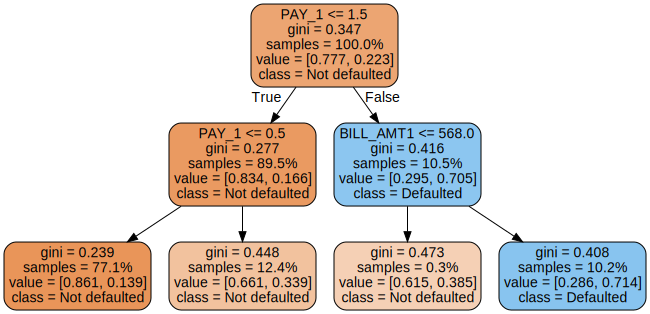

In [462]:
graph

In [463]:
# confirm the proportion of training samples where PAY_1 feature is less than or equal to 1.5
features_response[:-1].index('PAY_1')

4

In [464]:
X_train.shape

(21331, 17)

In [465]:
(X_train[:,4] <= 1.5).sum() / X_train.shape[0]

0.8946134733486475

In [466]:
# Confirm the class fractions (shown as value in the  nodes)
y_train.mean()

0.223102526838873

In [467]:
# Demonstrating a tree that grows without bounds
dt.max_depth=None

In [468]:
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [469]:
# Save a a .dot image file to disk
no_max_depth = tree.export_graphviz(dt, out_file=None,
                     filled=True, rounded=True,
                     feature_names=features_response[:-1],
                     proportion=True, class_names=['Not defaulted', 'Defaulted'])

In [470]:
# Save a a .dot image file to disk
tree.export_graphviz(dt, out_file='intermediate_data/chapter8tree1.dot',
                     filled=True, rounded=True,
                     feature_names=features_response[:-1],
                     proportion=True, class_names=['Not defaulted', 'Defaulted'])

#### Node impurity, misclassification rate

In [471]:
pm0 = np.linspace(0.01, 0.99, 99)       # fraction of negative class samples in a node
pm1 = 1 - pm0                           # corresponding fraction of positive class samples in a node

In [472]:
# For any node, the majority class is the prediction, and the minority proportion is misclassification rate
misclassification_rate = np.minimum(pm0,pm1) # minimum of negative class rate and positive class rate

In [473]:
misclassification_rate

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.49, 0.48, 0.47, 0.46, 0.45,
       0.44, 0.43, 0.42, 0.41, 0.4 , 0.39, 0.38, 0.37, 0.36, 0.35, 0.34,
       0.33, 0.32, 0.31, 0.3 , 0.29, 0.28, 0.27, 0.26, 0.25, 0.24, 0.23,
       0.22, 0.21, 0.2 , 0.19, 0.18, 0.17, 0.16, 0.15, 0.14, 0.13, 0.12,
       0.11, 0.1 , 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01])

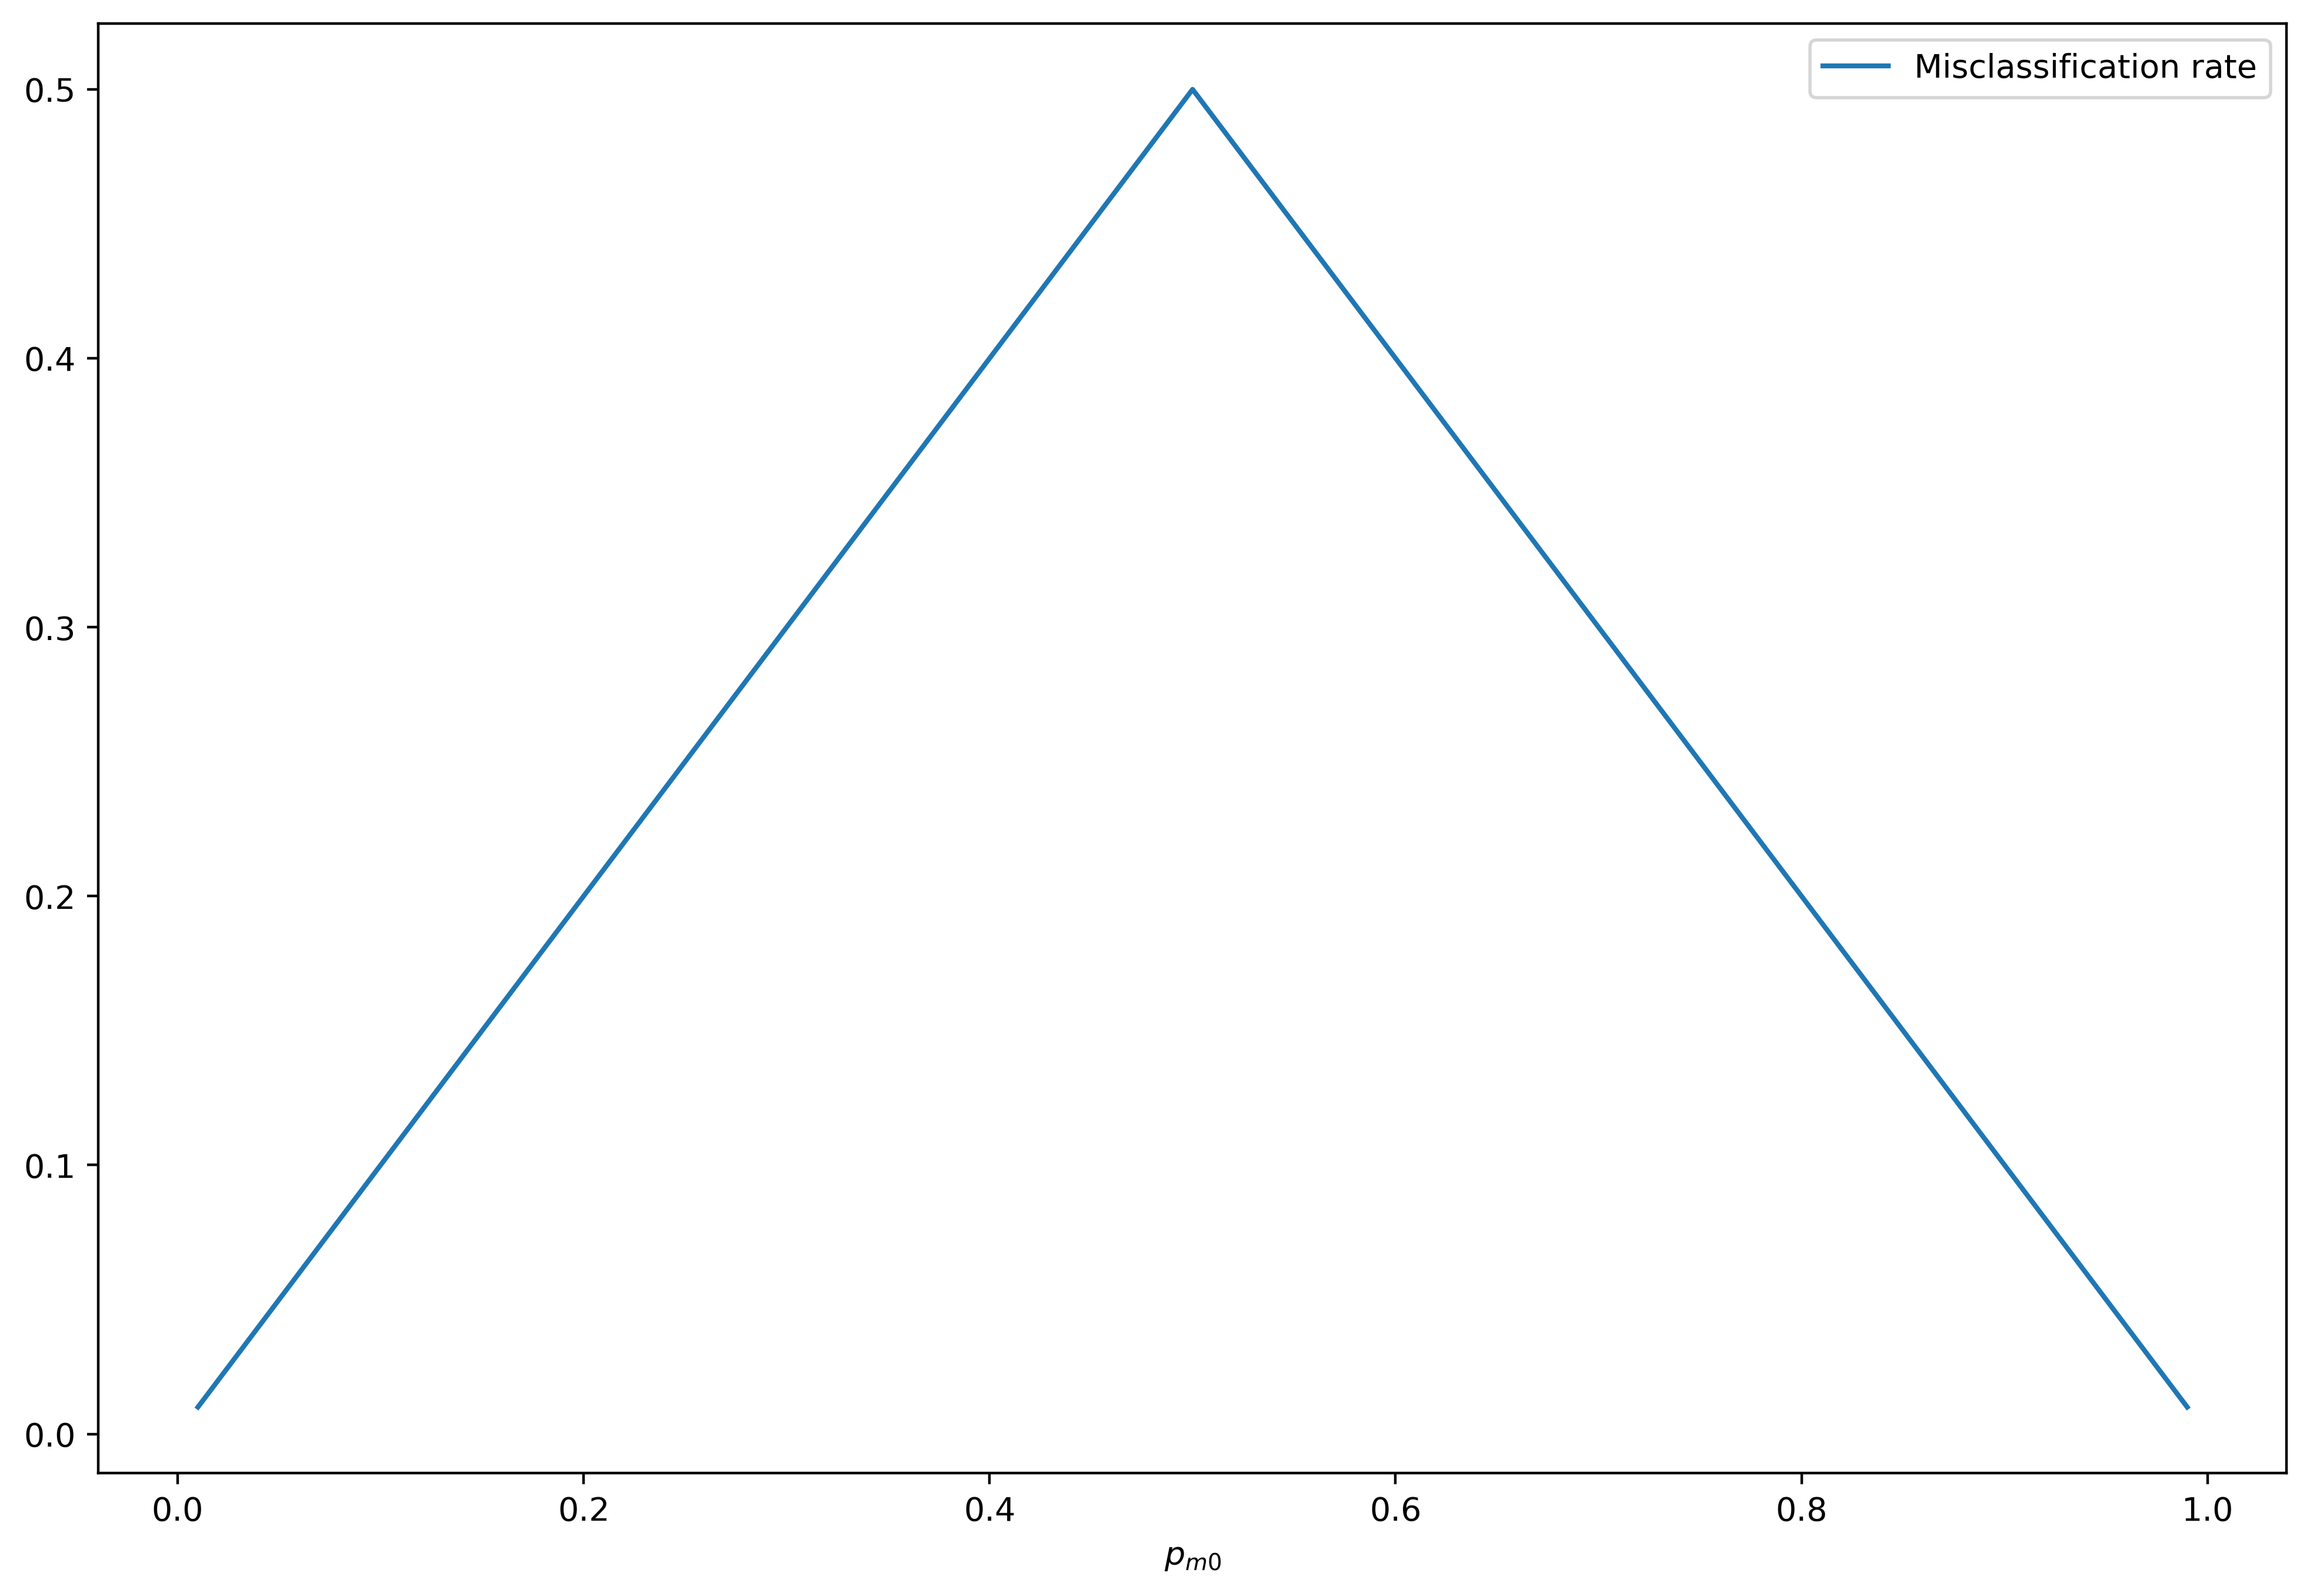

In [474]:
# Plotting the misclassification rate against the possible class fractions of the negative class
mpl.rcParams['figure.dpi'] = 400
plt.figure(figsize=(12,8))
plt.plot(pm0, misclassification_rate, label='Misclassification rate')
plt.xlabel('$p_{m0}$')
plt.legend()

From the plot above, its clear that misclassification rate is lower when the proportion of negative class in a node is closer to 0 or to 1. While misclassification rate is an intuitive measure of node impurity, there are better options for finding splits along features. Two of these are available in scikit-learn which are Gini impurity and cross-entropy.

Gini impurity=$\Sigma_k p_{mk}(1-p_{mk})$  k=classes (0,1), m=children nodes after split(left, right)

In the case of a binary classification, there are two classes, so the gini impurity for node m is:

gini = (pm0*(1-pm0)) + (pm1*(1-pm1))

cross entropy impurity= $-\Sigma_kp_{mk}log(pmk)$

In the case of a binary classification, there are two classes, so the cross-entropy impurity for node m is:

cross_ent = -1*((pm0 * np.log(pm0))  + (pm1 * np.log(pm1))) 

The last measure of impurity of course is the misclassification rate. For any node m, the majority class is the prediction, and the proportion of the minority class is the misclassification rate, ie $min(p_{mk})$ or $1-max(p_{mk})$

In [475]:
# Gini impurity
gini = (pm0*(1-pm0)) + (pm1*(1-pm1))

In [476]:
# Cross-entropy impurity
cross_ent = -1*((pm0 * np.log(pm0))  + (pm1 * np.log(pm1))) 

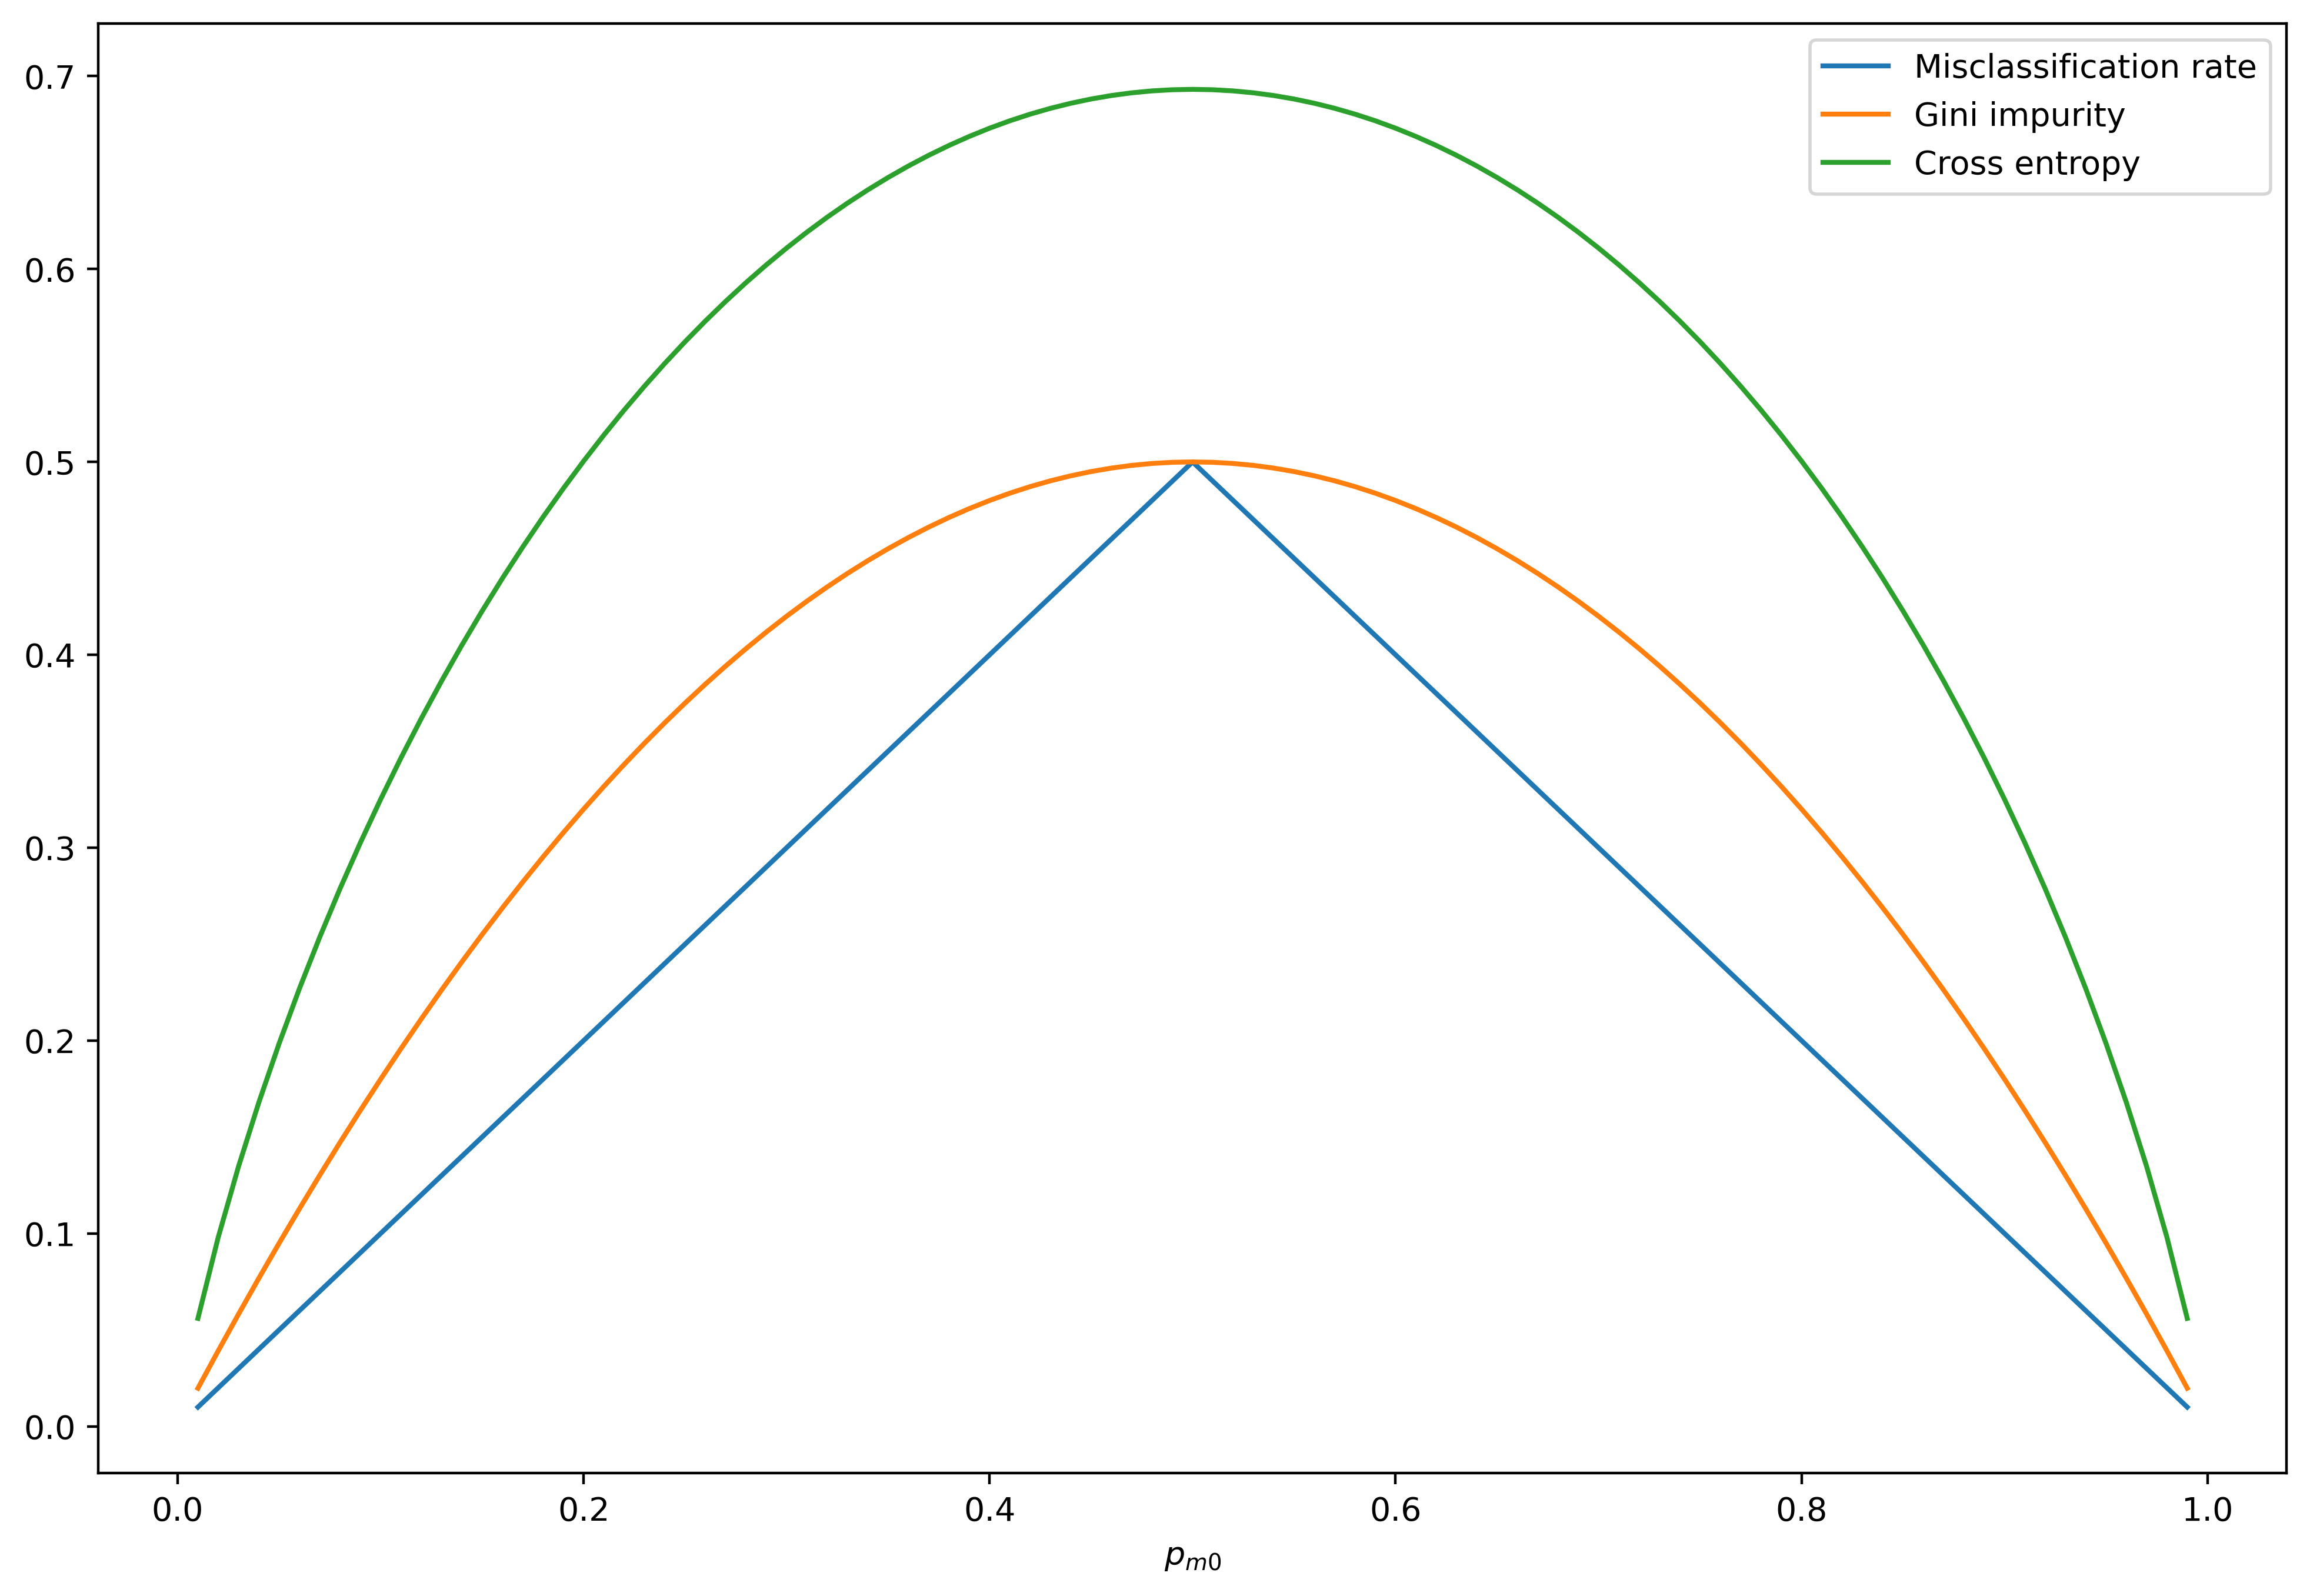

In [477]:
mpl.rcParams['figure.dpi'] = 400 
plt.figure(figsize=(12,8))
plt.plot(pm0, misclassification_rate, label='Misclassification rate')
plt.plot(pm0, gini, label='Gini impurity')
plt.plot(pm0, cross_ent, label='Cross entropy')
plt.xlabel('$p_{m0}$')
plt.legend()

In [478]:
np.minimum([1,2,4], [0,4,3])

array([0, 2, 3])

#### Using Decision Trees: Advantages and Predicted Probabilities

In [479]:
from sklearn.datasets import make_circles

In [480]:
X_circ, y_circ = make_circles(n_samples=300, shuffle=True,
                              noise=0.1, random_state=1, factor=0.4)

In [481]:
from matplotlib.colors import ListedColormap 

cm = plt.cm.RdBu                                    # continous colormap for background points from red to blue
cm_bright = ListedColormap(['#FF0000', '#0000FF'])  # hexcode colormap for dataset points (red, blue)

[]

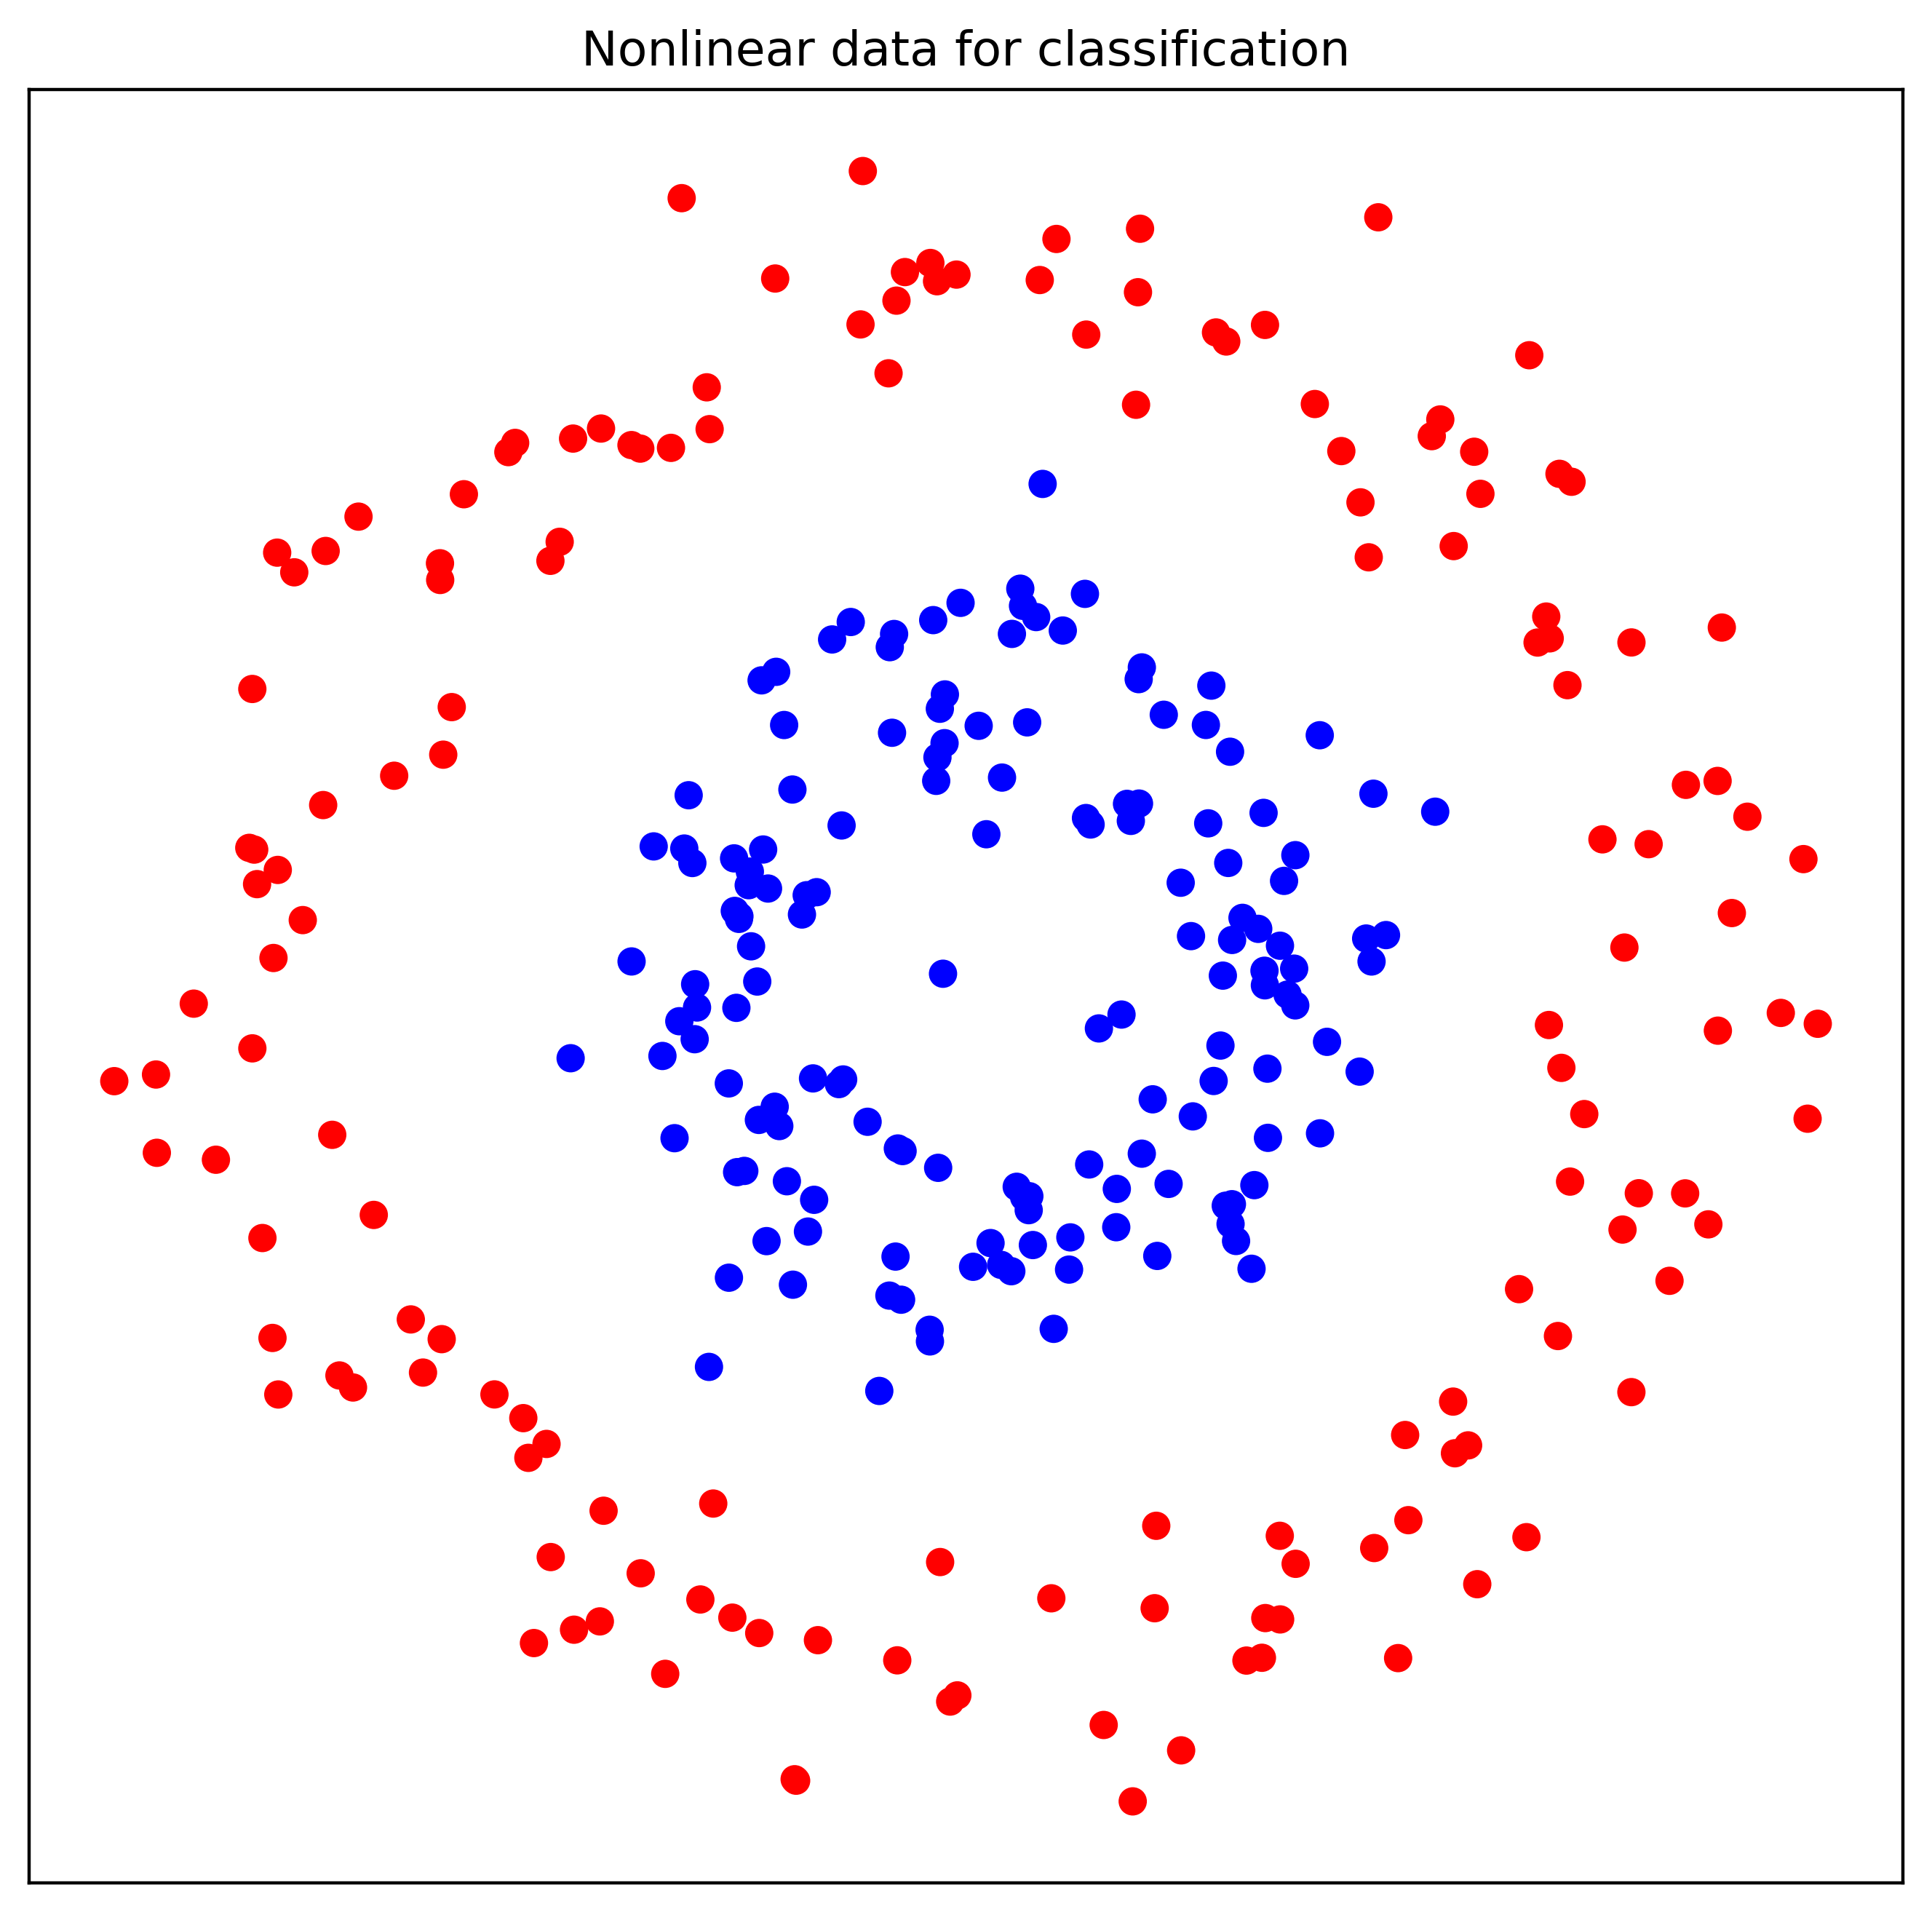

In [482]:
plt.figure(figsize=(12,8))
ax = plt.axes()
ax.scatter(X_circ[:,0], X_circ[:,1], c=y_circ, cmap=cm_bright) # color by label, colormap is hexcodes above
ax.set_aspect('equal')
ax.set_title('Nonlinear data for classification')
ax.set_xticks([])
ax.set_yticks([])

In [483]:
x_min, x_max = X_circ[:,0].min() - .5, X_circ[:,0].max() + .5        # min and max of feature 1 (x-axis)
y_min, y_max = X_circ[:,1].min() - .5, X_circ[:,1].max() + .5        # min and max of feature 2 (y-axix)
h = 0.02  # spacing for generating meshgrid points
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), 
                     np.arange(y_min, y_max, h))   # x-coord, y-coord of points covering plotted area

In [484]:
from sklearn.linear_model import LogisticRegression

In [485]:
classifiers = [tree.DecisionTreeClassifier(max_depth=4, random_state=4), # limit tree depth, repeatable run seed
                LogisticRegression()]   # logistic regression, no engineered features on dataset
titles = ['Decision Tree', 'Logistic Regression']

In [486]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve

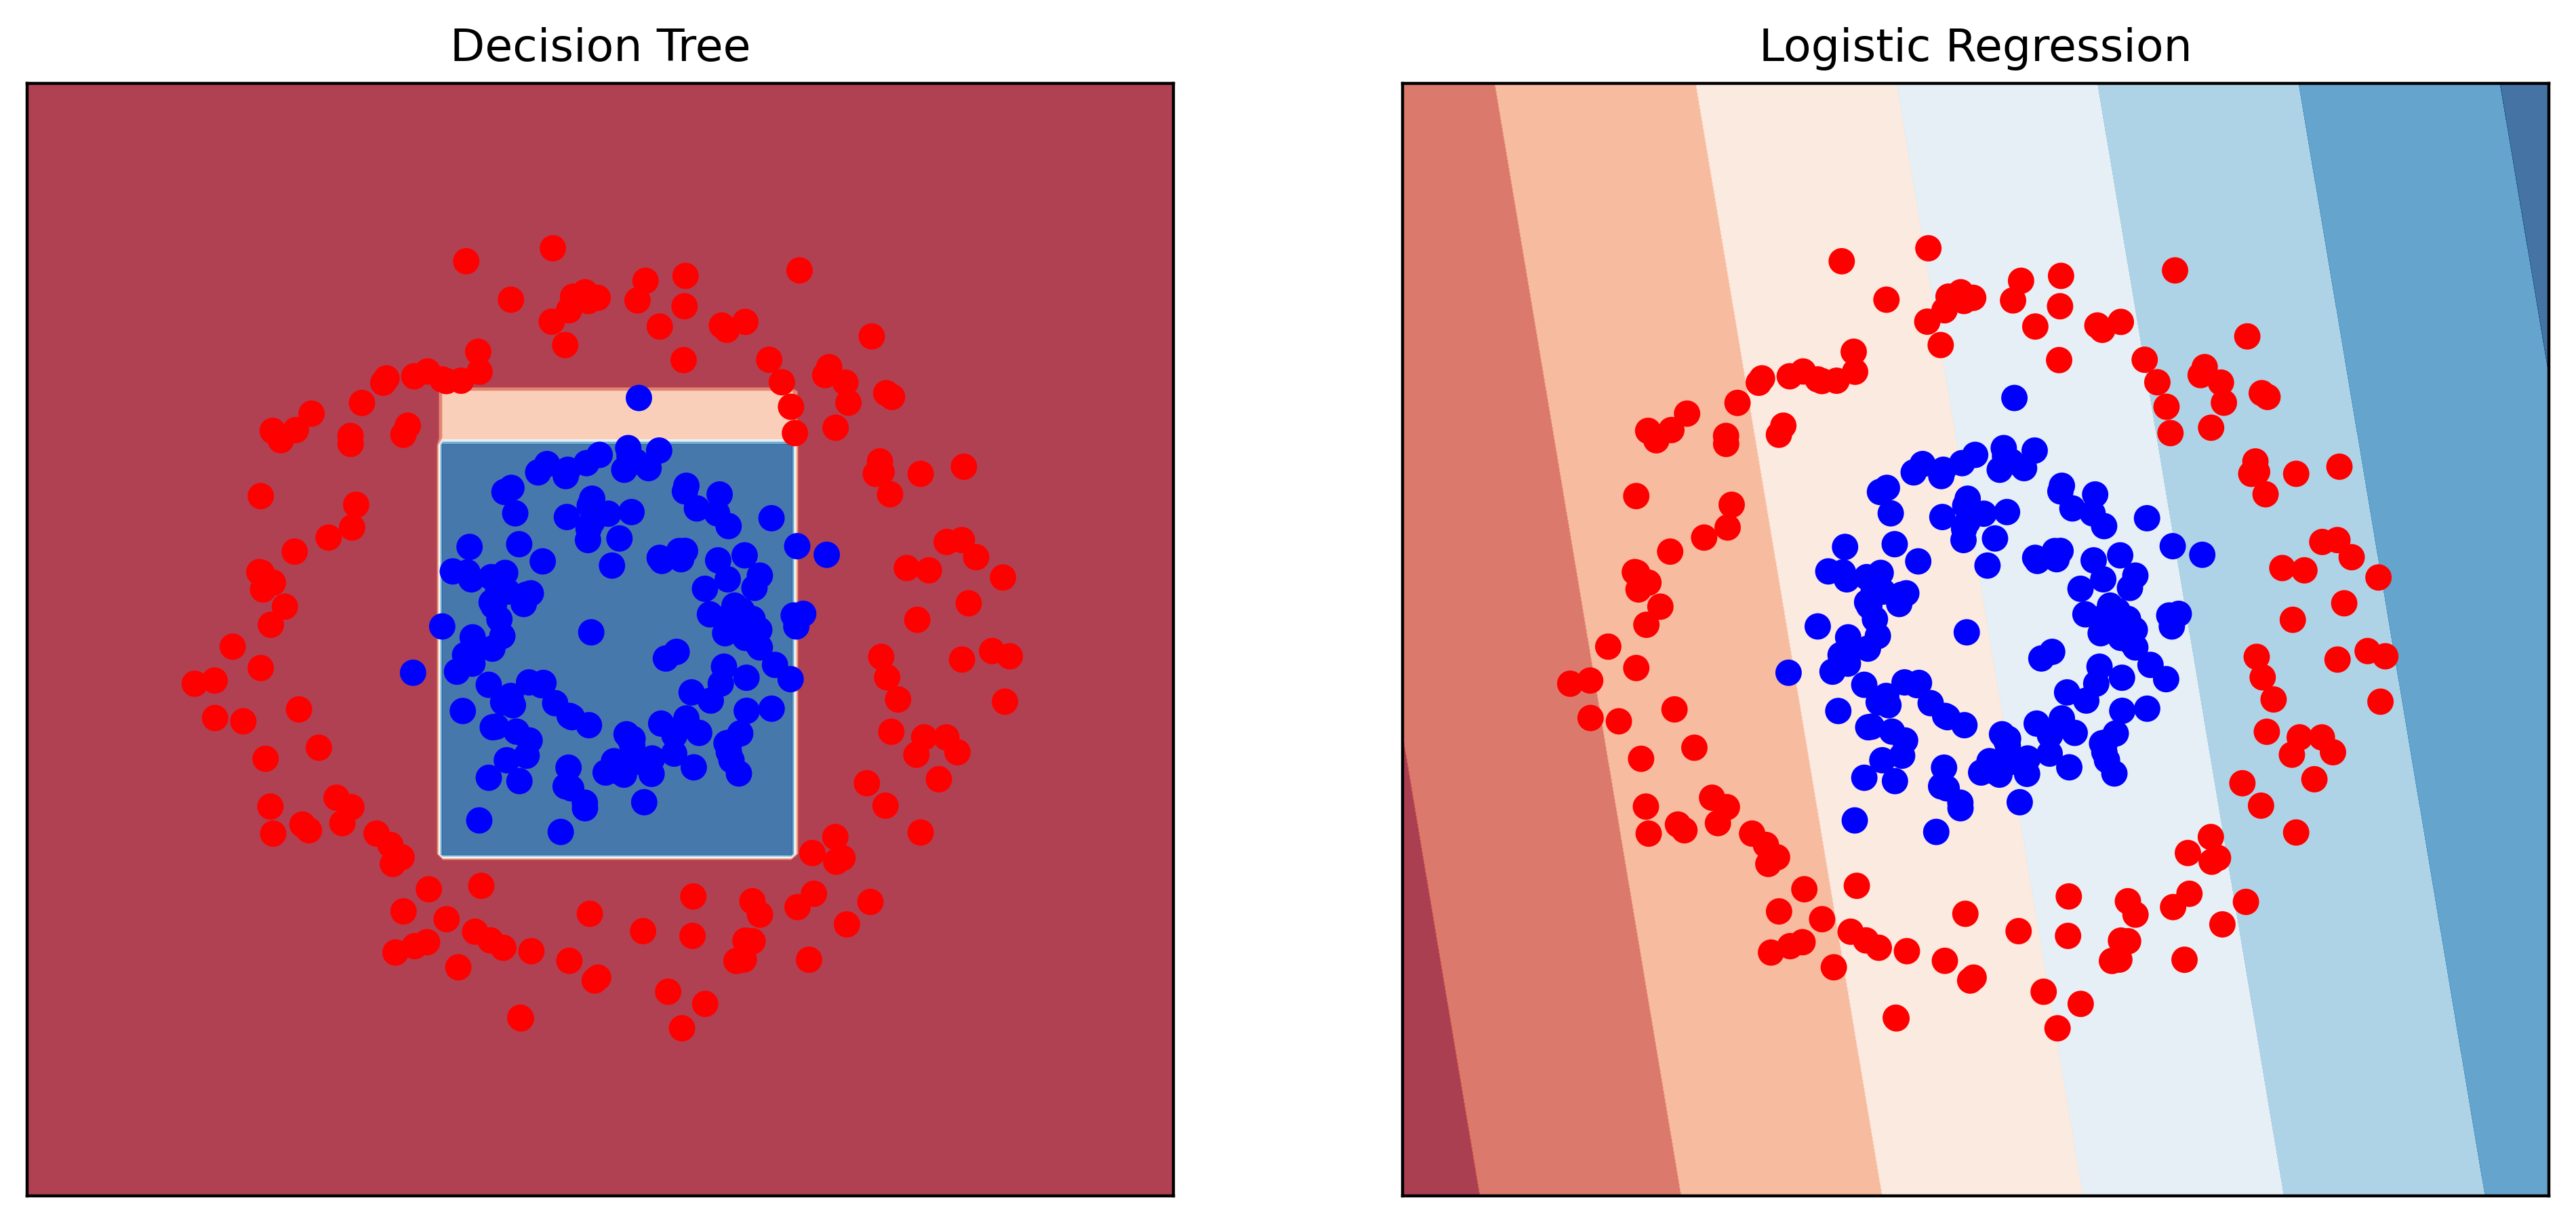

In [487]:
counter = 1
plt.figure(figsize=(12,8))
roc_auc_vals = []
roc_curve_vals = []
prec_rec_vals = []
for classif in classifiers:
    ax = plt.subplot(1,2,counter)
    classif.fit(X_circ, y_circ)
    Z = classif.predict_proba(np.c_[xx.ravel(),       # ravel plotted area points; concatenate into features
                                    yy.ravel()])[:,1] # predict positve class prob on plotted area points
    Z = Z.reshape(xx.shape) # reshape prob predictions for each point, same shape as original

    y_pred_proba = classif.predict_proba(X_circ)[:,1]       # positive class probability on dataset
    roc_auc_classif = roc_auc_score(y_circ, y_pred_proba)   # area under roc curve
    roc_auc_vals.append(np.round(roc_auc_classif,6))        # store area under roc curve
    roc_curve_vals.append(roc_curve(y_circ, y_pred_proba))
    prec_rec_vals.append(precision_recall_curve(y_circ, y_pred_proba))

    a = ax.contourf(xx, yy, Z, 
                cmap=cm, alpha=0.8) # filled contours; colormap of probability of positive class
    
    ax.scatter(X_circ[:,0], X_circ[:,1], 
                c=y_circ, cmap=cm_bright) # color by label, colormap is hexcodes above
    ax.set_aspect('equal') # Set the aspect ratio of the axes scaling, i.e. y/x-scale to aspect=1
    ax.set_title(titles[counter-1])
    ax.set_xticks([])
    ax.set_yticks([])
    counter += 1

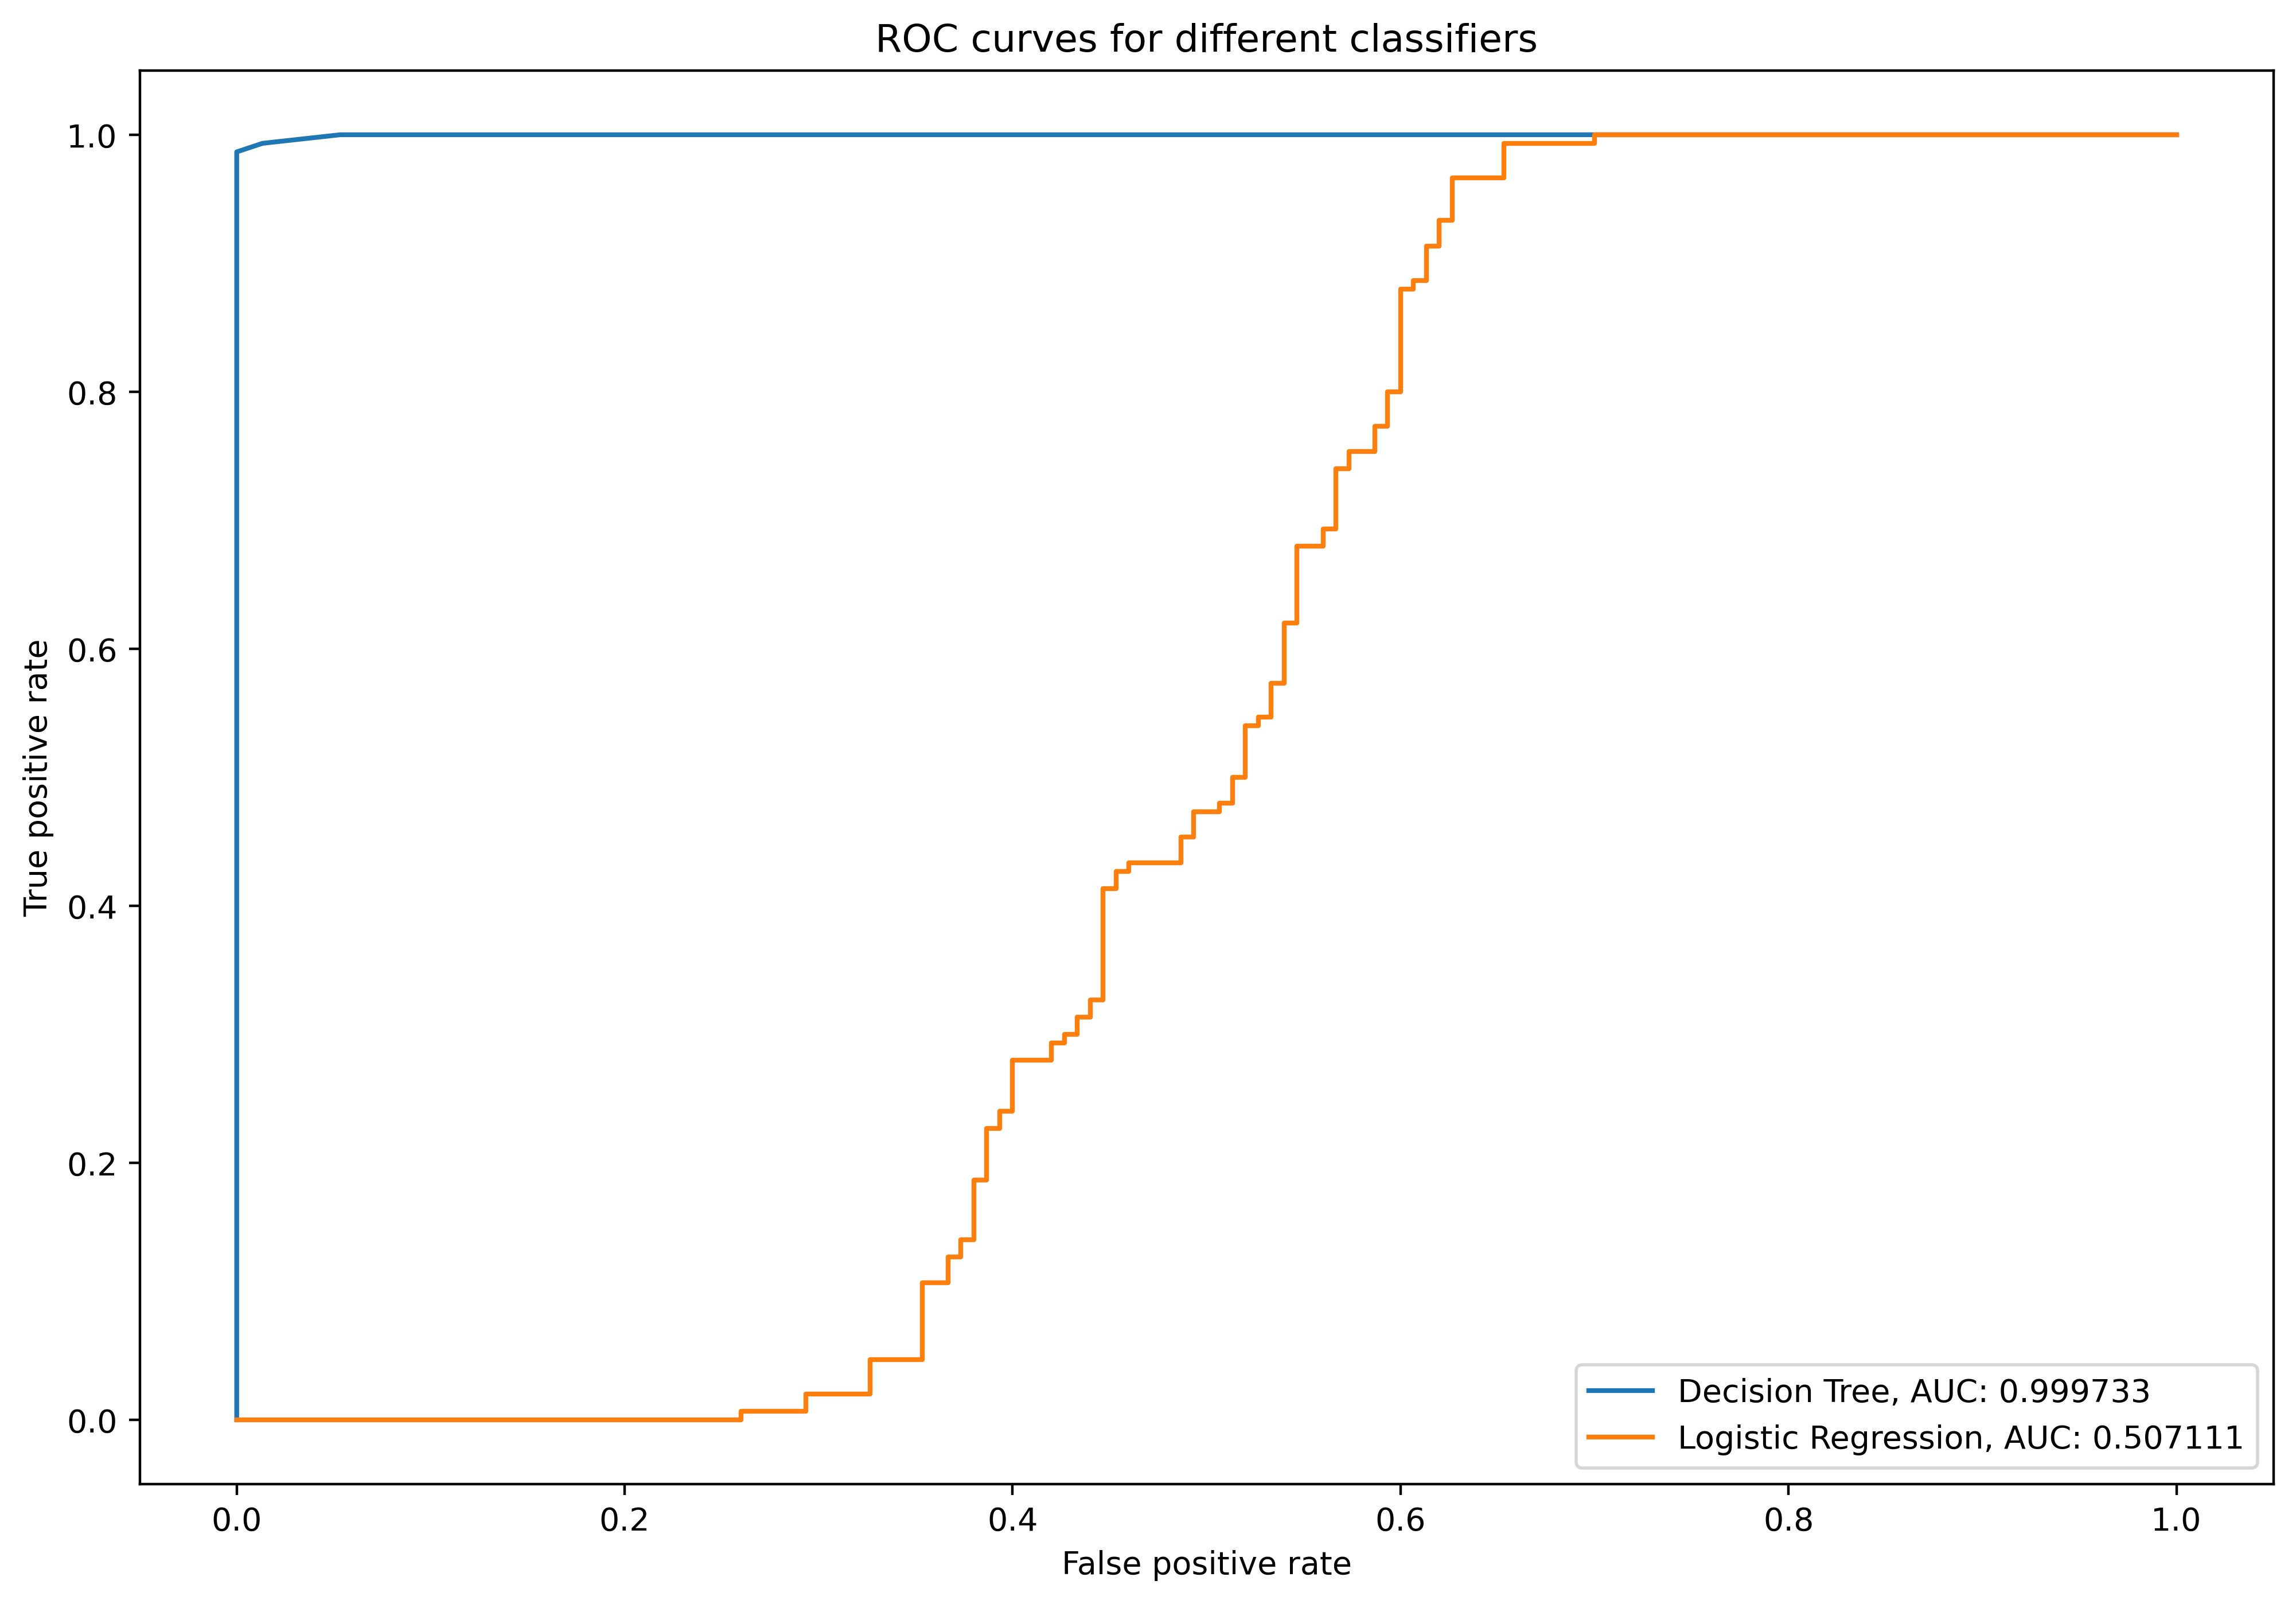

In [488]:
# Access the true and false positive rates in order to plot the ROC curves for each fold
plt.figure(figsize=(12,8))
counter = 1
for counter in range(len(classifiers)):
    fpr = roc_curve_vals[counter][0]
    tpr = roc_curve_vals[counter][1]
    plt.plot(fpr, tpr, label=f'{titles[counter]}, AUC: {roc_auc_vals[counter]}')
    
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curves for different classifiers')
    plt.legend()

#### Using GridSearchCV to find optimal hyperparameters 

In [489]:
from sklearn.model_selection import GridSearchCV

How does the depth of the tree relate to the number of leaves and the number of samples in each training fold.

- If we have k-folds for cross-validation, each training subset will contain (k-1)*training_data/k. Case study data has 21331 samples, so each training subset will contain ~ 16000 samples.
- A tree that splits at every node before the last level, with $n$ levels, has $2n$ leaf nodes. Therefore, a tree with $L$ leaf nodes has a depth of approximately $log_2(L)$.
- In the limiting case, if tree grows deep enough, so every leaf node has one training sample for a given fold, the depth will be $log_2(16000)$ = 14. So 14 is the theoretical limit to the depth of a tree. Such a tree will overfit, but this gives an idea of the range of values we may wish to explore for max_depth hyperparameter. Here, we will explore depths from 1 to 12.

In [490]:
X_train.shape

(21331, 17)

In [491]:
# if we use 4-fold cross-validation, 3/4 of the data will be used for training
21331*3/4 #

15998.25

In [492]:
# if tree is so deep, it has one training sample per 1 leaf node, the depth will be
np.log2(16000)

13.965784284662087

In [493]:
# dictionary of hyperparameter key : values list
params = {'max_depth': [1, 2, 4, 6, 8, 10, 12]}

In [494]:
# initialize decision tree
dt = tree.DecisionTreeClassifier()

In [495]:
cv = GridSearchCV(estimator=dt,                 # model object
                  param_grid=params,            # hyperparameter names and values
                  scoring='roc_auc',            # model assessment method
                  n_jobs=None,                  # number of parallel processing jobs 
                  refit=True,                   # refit estimator with best hyperparameters
                  cv=4,                         # number of folds to use for cross-validation
                  verbose=1,                    # how much output from cross-validation procedure
                  pre_dispatch=None,            # jobs to dispatch (related to parallel processing)
                  error_score=np.nan,           # what to do if an error happens during model fitting
                  return_train_score=True       # include fold train scores to .cv_results_; to assess overfit
                  )

In [496]:
cv.fit(X_train, y_train)

Fitting 4 folds for each of 7 candidates, totalling 28 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [1, 2, 4, 6, 8, 10, 12]},
             pre_dispatch=None, return_train_score=True, scoring='roc_auc',
             verbose=1)

In [497]:
cv.best_params_

{'max_depth': 6}

In [498]:
# examine cv.cv_results_ attribute after cross-validation using a pandas dataframe
cv_results_df = pd.DataFrame(cv.cv_results_) # contains training_scores because return_train_score=True
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.018227,0.000841,0.001873,0.000027,1,{'max_depth': 1},0.639514,0.643398,0.651891,0.650753,0.646389,0.005136,7,0.648680,0.647384,0.644553,0.644934,0.646388,0.001712
1,0.033362,0.001696,0.001754,0.000204,2,{'max_depth': 2},0.695134,0.699022,0.713376,0.699510,0.701761,0.006917,5,0.704034,0.702700,0.698113,0.702535,0.701845,0.002232
2,0.060400,0.000092,0.001767,0.000038,4,{'max_depth': 4},0.732720,0.740116,0.746946,0.743731,0.740878,0.005294,2,0.756882,0.752256,0.749368,0.753055,0.752890,0.002682
3,0.087936,0.000123,0.001885,0.000018,6,{'max_depth': 6},0.745252,0.746910,0.750202,0.740774,0.745785,0.003397,1,0.782202,0.780044,0.775228,0.774750,0.778056,0.003165
4,0.115587,0.002389,0.002240,0.000235,8,{'max_depth': 8},0.729111,0.731228,0.749867,0.731578,0.735446,0.008379,3,0.811837,0.808353,0.803345,0.802048,0.806396,0.003926
5,0.139174,0.000778,0.002074,0.000071,10,{'max_depth': 10},0.708992,0.705601,0.718509,0.714009,0.711778,0.004904,4,0.848809,0.854451,0.841285,0.836521,0.845267,0.006878
6,0.162036,0.000774,0.002089,0.000036,12,{'max_depth': 12},0.673440,0.657276,0.675561,0.676142,0.670605,0.007761,6,0.890159,0.903326,0.885308,0.875998,0.888698,0.009860


In [499]:
cv_results_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'params', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

Text(0, 0.5, 'ROC AUC')

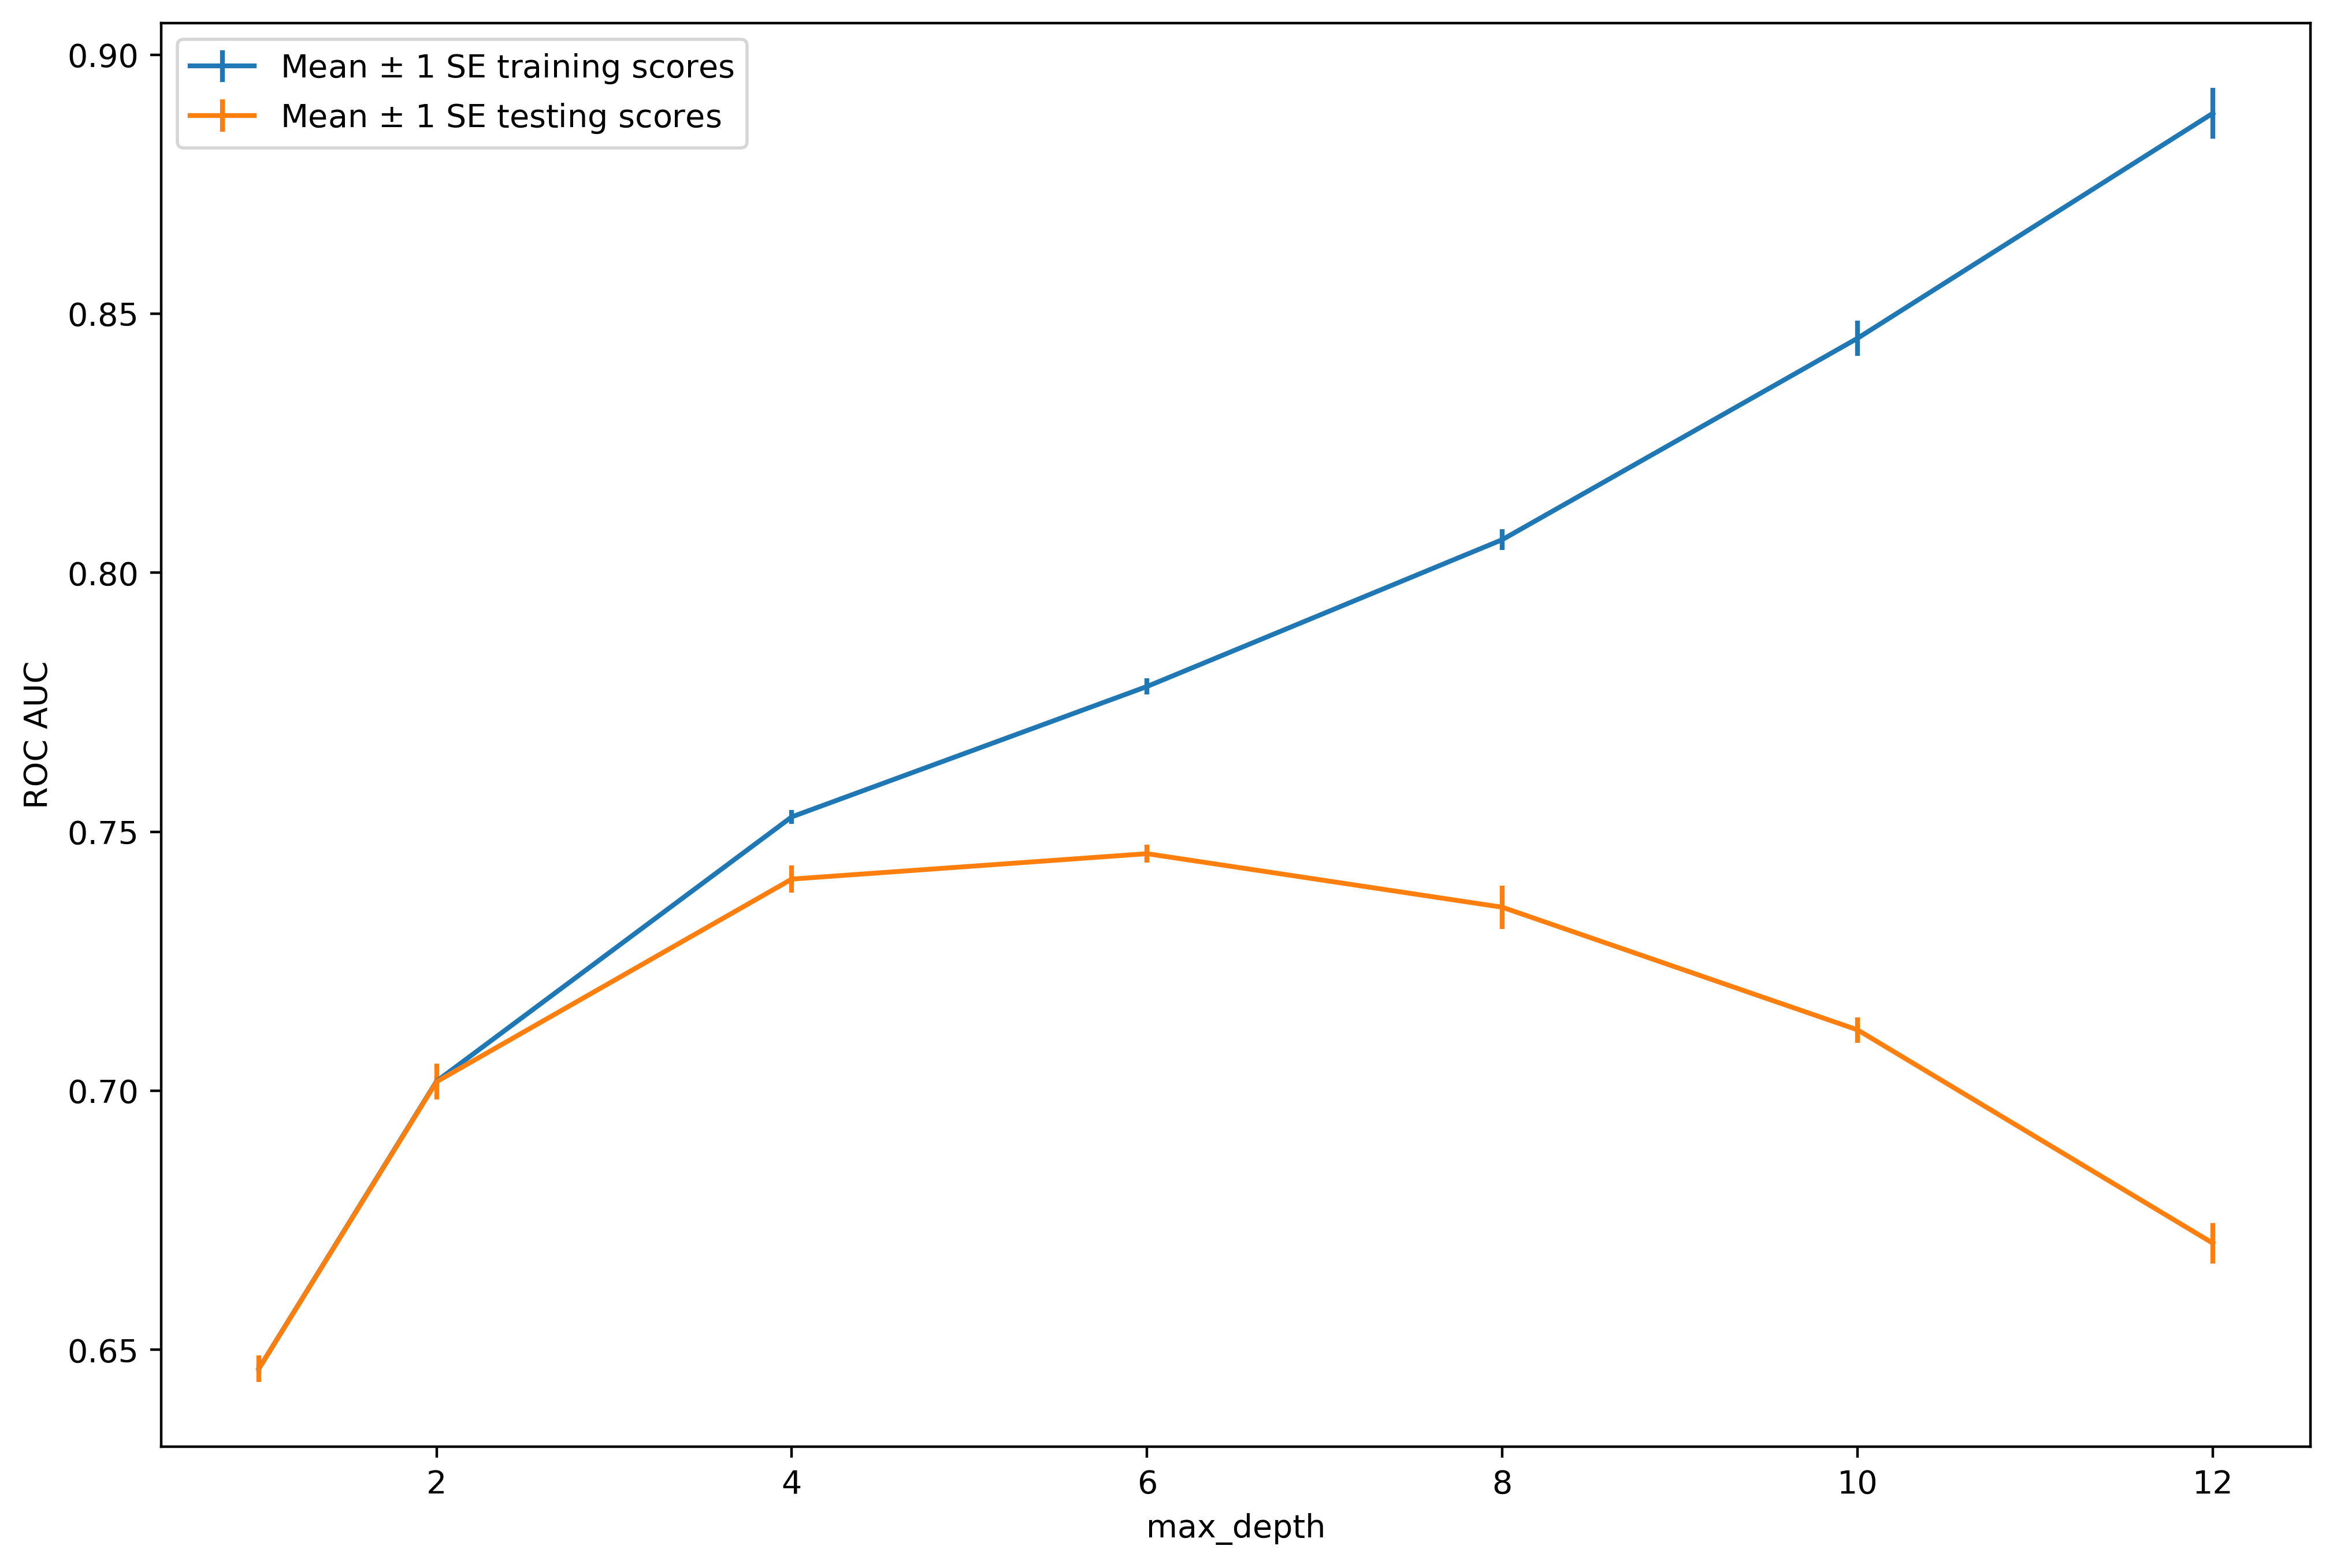

In [500]:
# Plot line of mean test / train score per hyperparameter with error bar (standard errr), 
plt.figure(figsize=(12,8))
ax = plt.axes()
ax.errorbar(cv_results_df['param_max_depth'],       # x-axis of line plot
            cv_results_df['mean_train_score'],      # y-axis of line plot
            yerr=cv_results_df['std_train_score'] / np.sqrt(4), # standard error as error bar
            label='Mean $\pm$ 1 SE training scores')
ax.errorbar(cv_results_df['param_max_depth'],
            cv_results_df['mean_test_score'],
            yerr=cv_results_df['std_test_score'] / np.sqrt(4),
            label='Mean $\pm$ 1 SE testing scores')
ax.legend()
plt.xlabel('max_depth')
plt.ylabel('ROC AUC')

In [501]:
a = pd.DataFrame({'features': features_response[:-1],
              'feature_importances': cv.best_estimator_.feature_importances_})
a.sort_values(by='feature_importances',
              ascending=False)

,features,feature_importances
4,PAY_1,0.807605
12,PAY_AMT2,0.039383
0,LIMIT_BAL,0.031765
5,BILL_AMT1,0.030482
13,PAY_AMT3,0.022009
3,AGE,0.015354
14,PAY_AMT4,0.010029
16,PAY_AMT6,0.009168
10,BILL_AMT6,0.007716
15,PAY_AMT5,0.006349


### Random Forests: Ensembles of Decision Trees

In [502]:
from sklearn.ensemble import RandomForestClassifier

In [503]:
rf = RandomForestClassifier(n_estimators=10,        # just for initialization, we will cross-validate this
                            criterion='gini',
                            max_depth=3,            # our forest will contain trees of max_depth 3
                            min_samples_split=2,
                            min_samples_leaf=1,
                            min_weight_fraction_leaf=0.0,
                            max_features='sqrt',
                            max_leaf_nodes=None,
                            min_impurity_decrease=0.0,
                            bootstrap=True,
                            oob_score=False,
                            n_jobs=None,
                            random_state=4,
                            verbose=0,
                            warm_start=False,
                            class_weight=None)

In [504]:
# parameter grid
rf_params_ex = {'n_estimators': list(range(10, 110, 10))}

In [505]:
rf_params_ex

{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}

In [506]:
# grid search cross-validation
cv_rf_ex = GridSearchCV(estimator=rf,
                        param_grid=rf_params_ex,
                        scoring='roc_auc',
                        n_jobs=None,
                        refit=True,
                        cv=4,
                        verbose=1,
                        pre_dispatch=None,
                        error_score=np.nan,
                        return_train_score=True)

In [507]:
cv_rf_ex.fit(X_train, y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(max_depth=3, n_estimators=10,
                                              random_state=4),
             param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100]},
             pre_dispatch=None, return_train_score=True, scoring='roc_auc',
             verbose=1)

In [508]:
cv_rf_ex_results_df = pd.DataFrame(cv_rf_ex.cv_results_)

In [509]:
cv_rf_ex_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.097910,0.004562,0.004337,0.000203,10,{'n_estimators': 10},0.739183,0.746599,0.772127,0.771322,0.757308,0.014656,10,0.767973,0.767158,0.760550,0.763683,0.764841,0.002955
1,0.190665,0.008401,0.008055,0.002701,20,{'n_estimators': 20},0.745612,0.753712,0.777616,0.771737,0.762169,0.012998,9,0.772819,0.771499,0.765944,0.765395,0.768914,0.003284
2,0.271088,0.004676,0.008646,0.000057,30,{'n_estimators': 30},0.747259,0.754154,0.777954,0.771825,0.762798,0.012524,7,0.774655,0.772100,0.765026,0.766697,0.769620,0.003910
3,0.358194,0.000757,0.010891,0.000051,40,{'n_estimators': 40},0.746682,0.754553,0.777709,0.773134,0.763020,0.012813,4,0.774300,0.772642,0.765051,0.765876,0.769467,0.004057
4,0.450472,0.001239,0.013227,0.000048,50,{'n_estimators': 50},0.748009,0.755878,0.779465,0.771250,0.763651,0.012379,1,0.775241,0.774025,0.765732,0.766947,0.770486,0.004191
5,0.539394,0.001303,0.015437,0.000040,60,{'n_estimators': 60},0.748437,0.755604,0.779478,0.770978,0.763624,0.012252,2,0.775419,0.773615,0.766133,0.767032,0.770550,0.004031
6,0.631360,0.002952,0.017845,0.000160,70,{'n_estimators': 70},0.747491,0.754465,0.779104,0.771023,0.763021,0.012620,3,0.774420,0.773379,0.765960,0.766174,0.769983,0.003934
7,0.718077,0.001103,0.020008,0.000072,80,{'n_estimators': 80},0.747424,0.754488,0.778753,0.770872,0.762884,0.012502,5,0.774234,0.773257,0.765978,0.766220,0.769922,0.003840
8,0.808337,0.001493,0.022326,0.000080,90,{'n_estimators': 90},0.747097,0.753794,0.778507,0.770426,0.762456,0.012571,8,0.774095,0.772973,0.766022,0.765748,0.769709,0.003846
9,0.897403,0.001897,0.024755,0.000139,100,{'n_estimators': 100},0.747221,0.753924,0.779195,0.770937,0.762819,0.012811,6,0.774340,0.773598,0.766103,0.766914,0.770238,0.003750


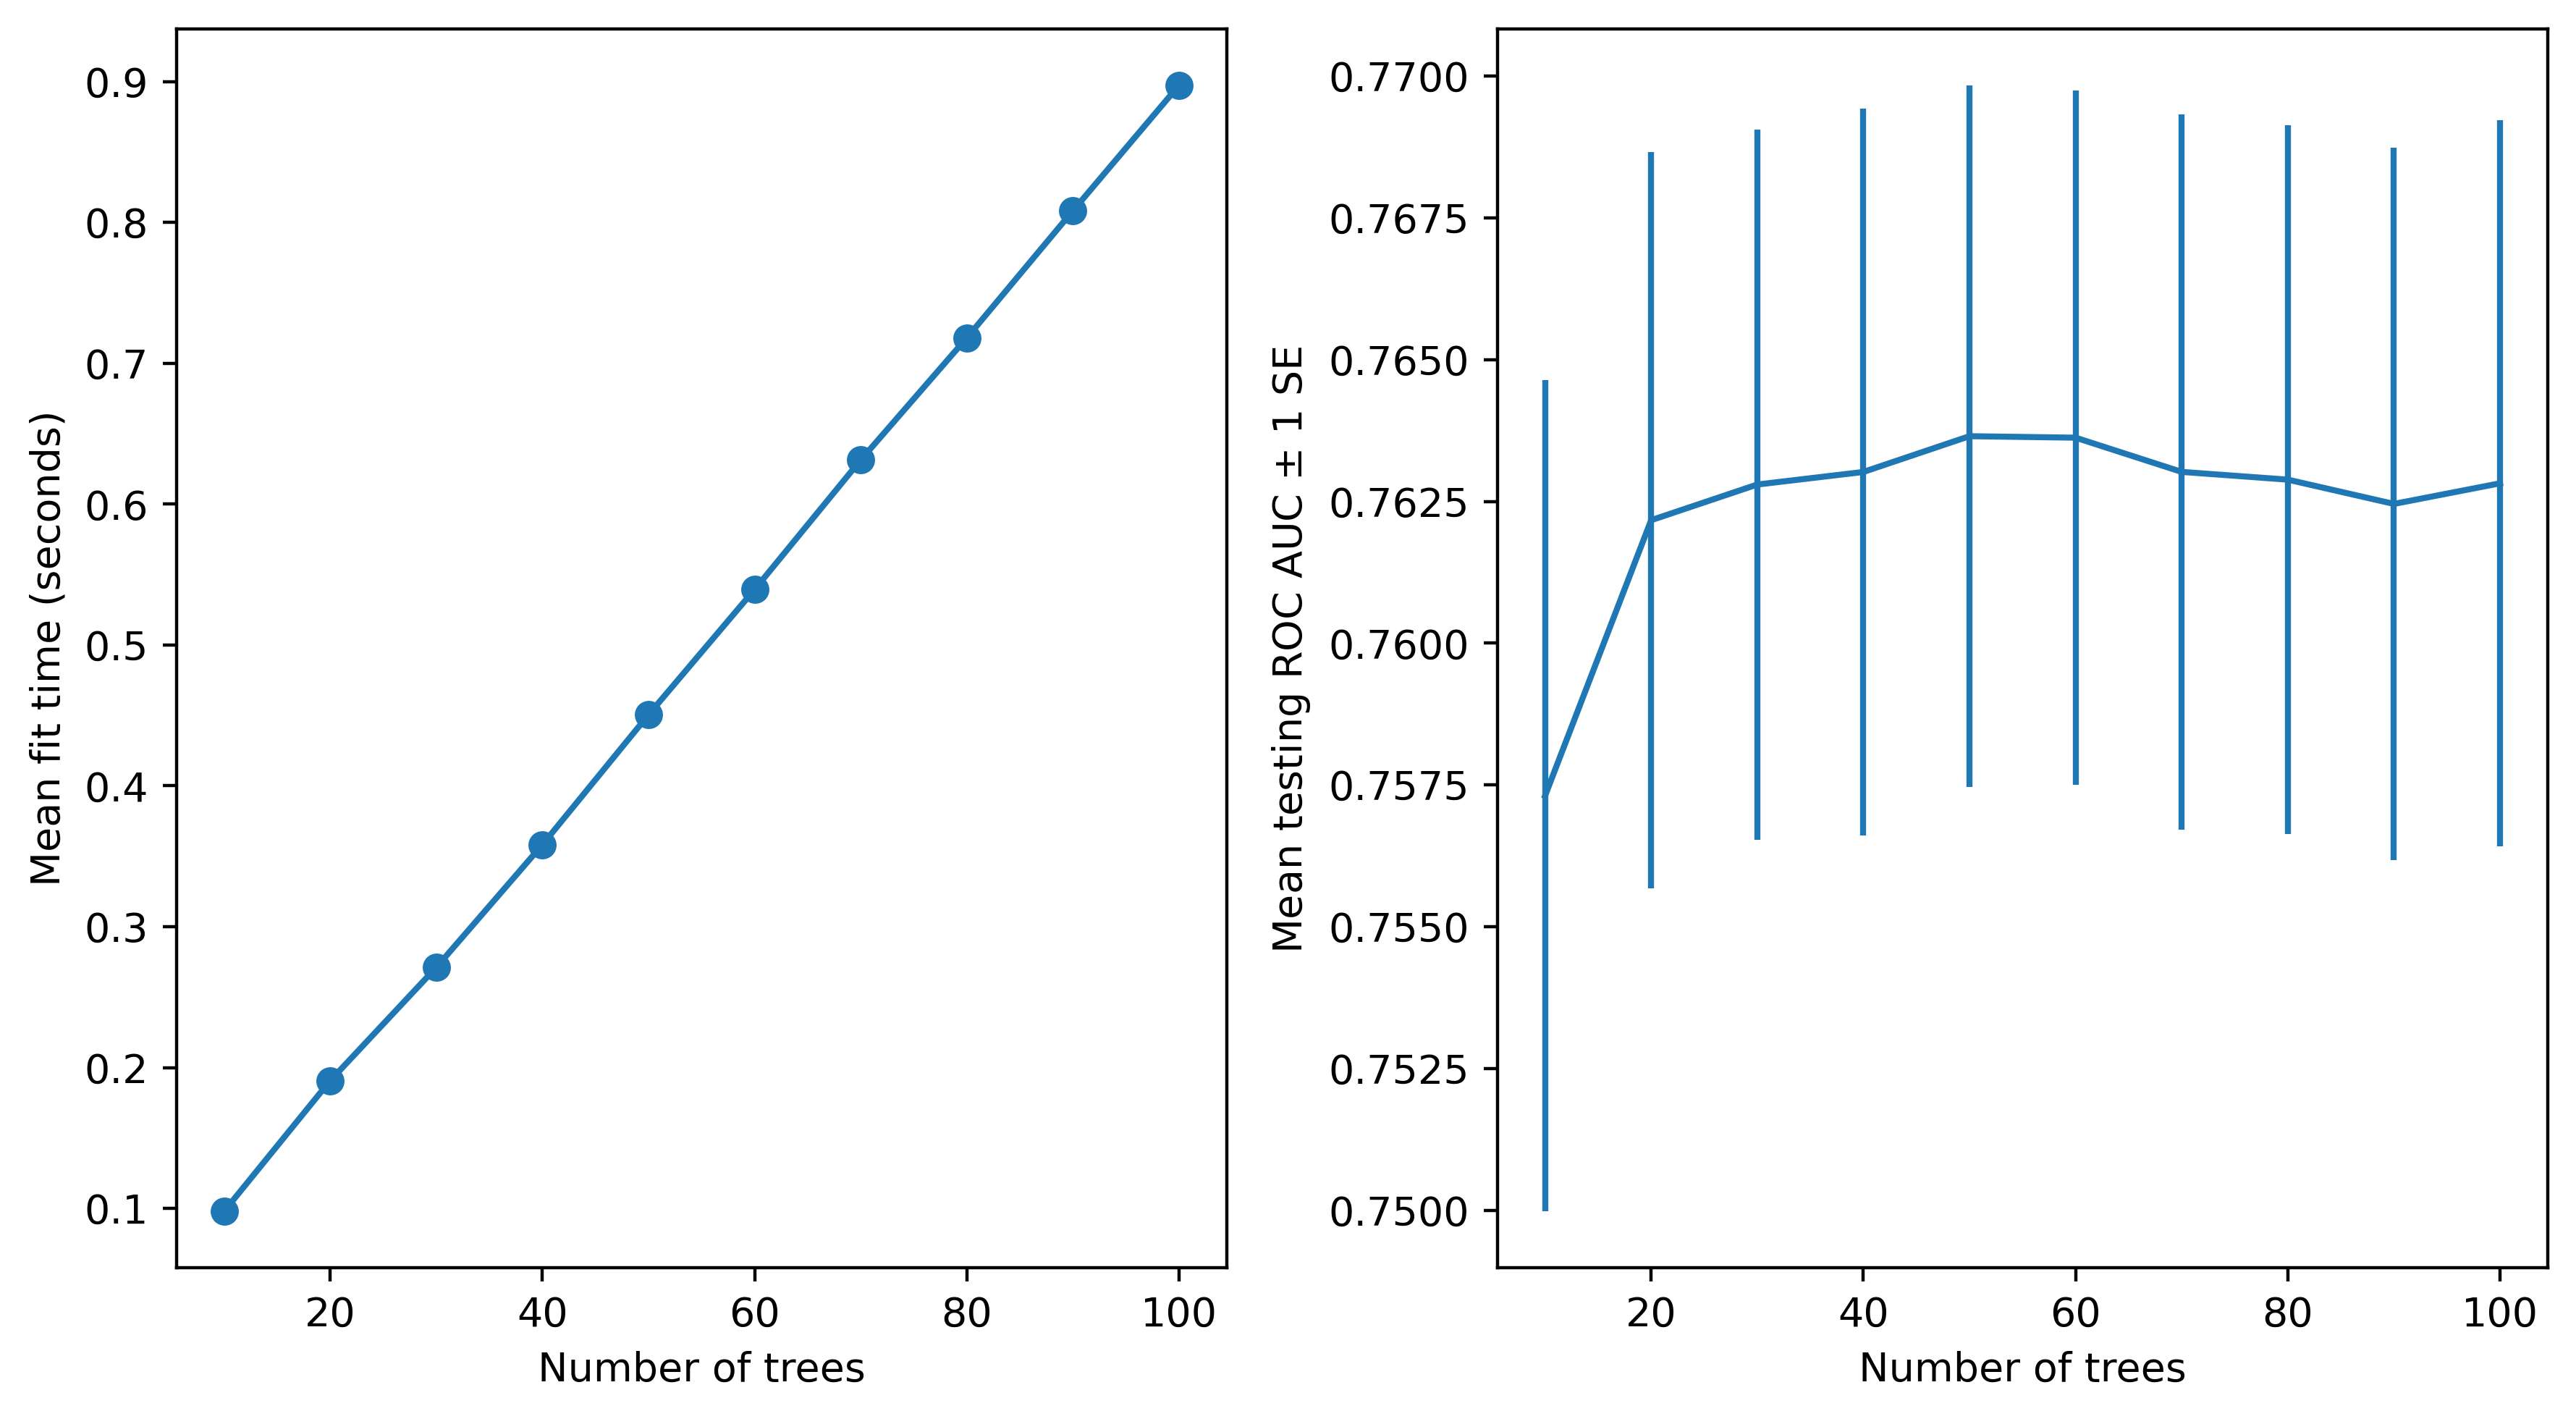

In [510]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))
# we expect fit time to vary linearly with number of trees
axs[0].plot(cv_rf_ex_results_df['param_n_estimators'],
            cv_rf_ex_results_df['mean_fit_time'],
            '-o')
axs[0].set_xlabel('Number of trees')
axs[0].set_ylabel('Mean fit time (seconds)')

axs[1].errorbar(cv_rf_ex_results_df['param_n_estimators'],
                cv_rf_ex_results_df['mean_test_score'],
                yerr=cv_rf_ex_results_df['std_test_score']/np.sqrt(4)) # standard error of mean_test_score
axs[1].set_xlabel('Number of trees')
axs[1].set_ylabel('Mean testing ROC AUC $\pm$ 1 SE ')
plt.tight_layout()

Text(0, 0.5, 'ROC AUC')

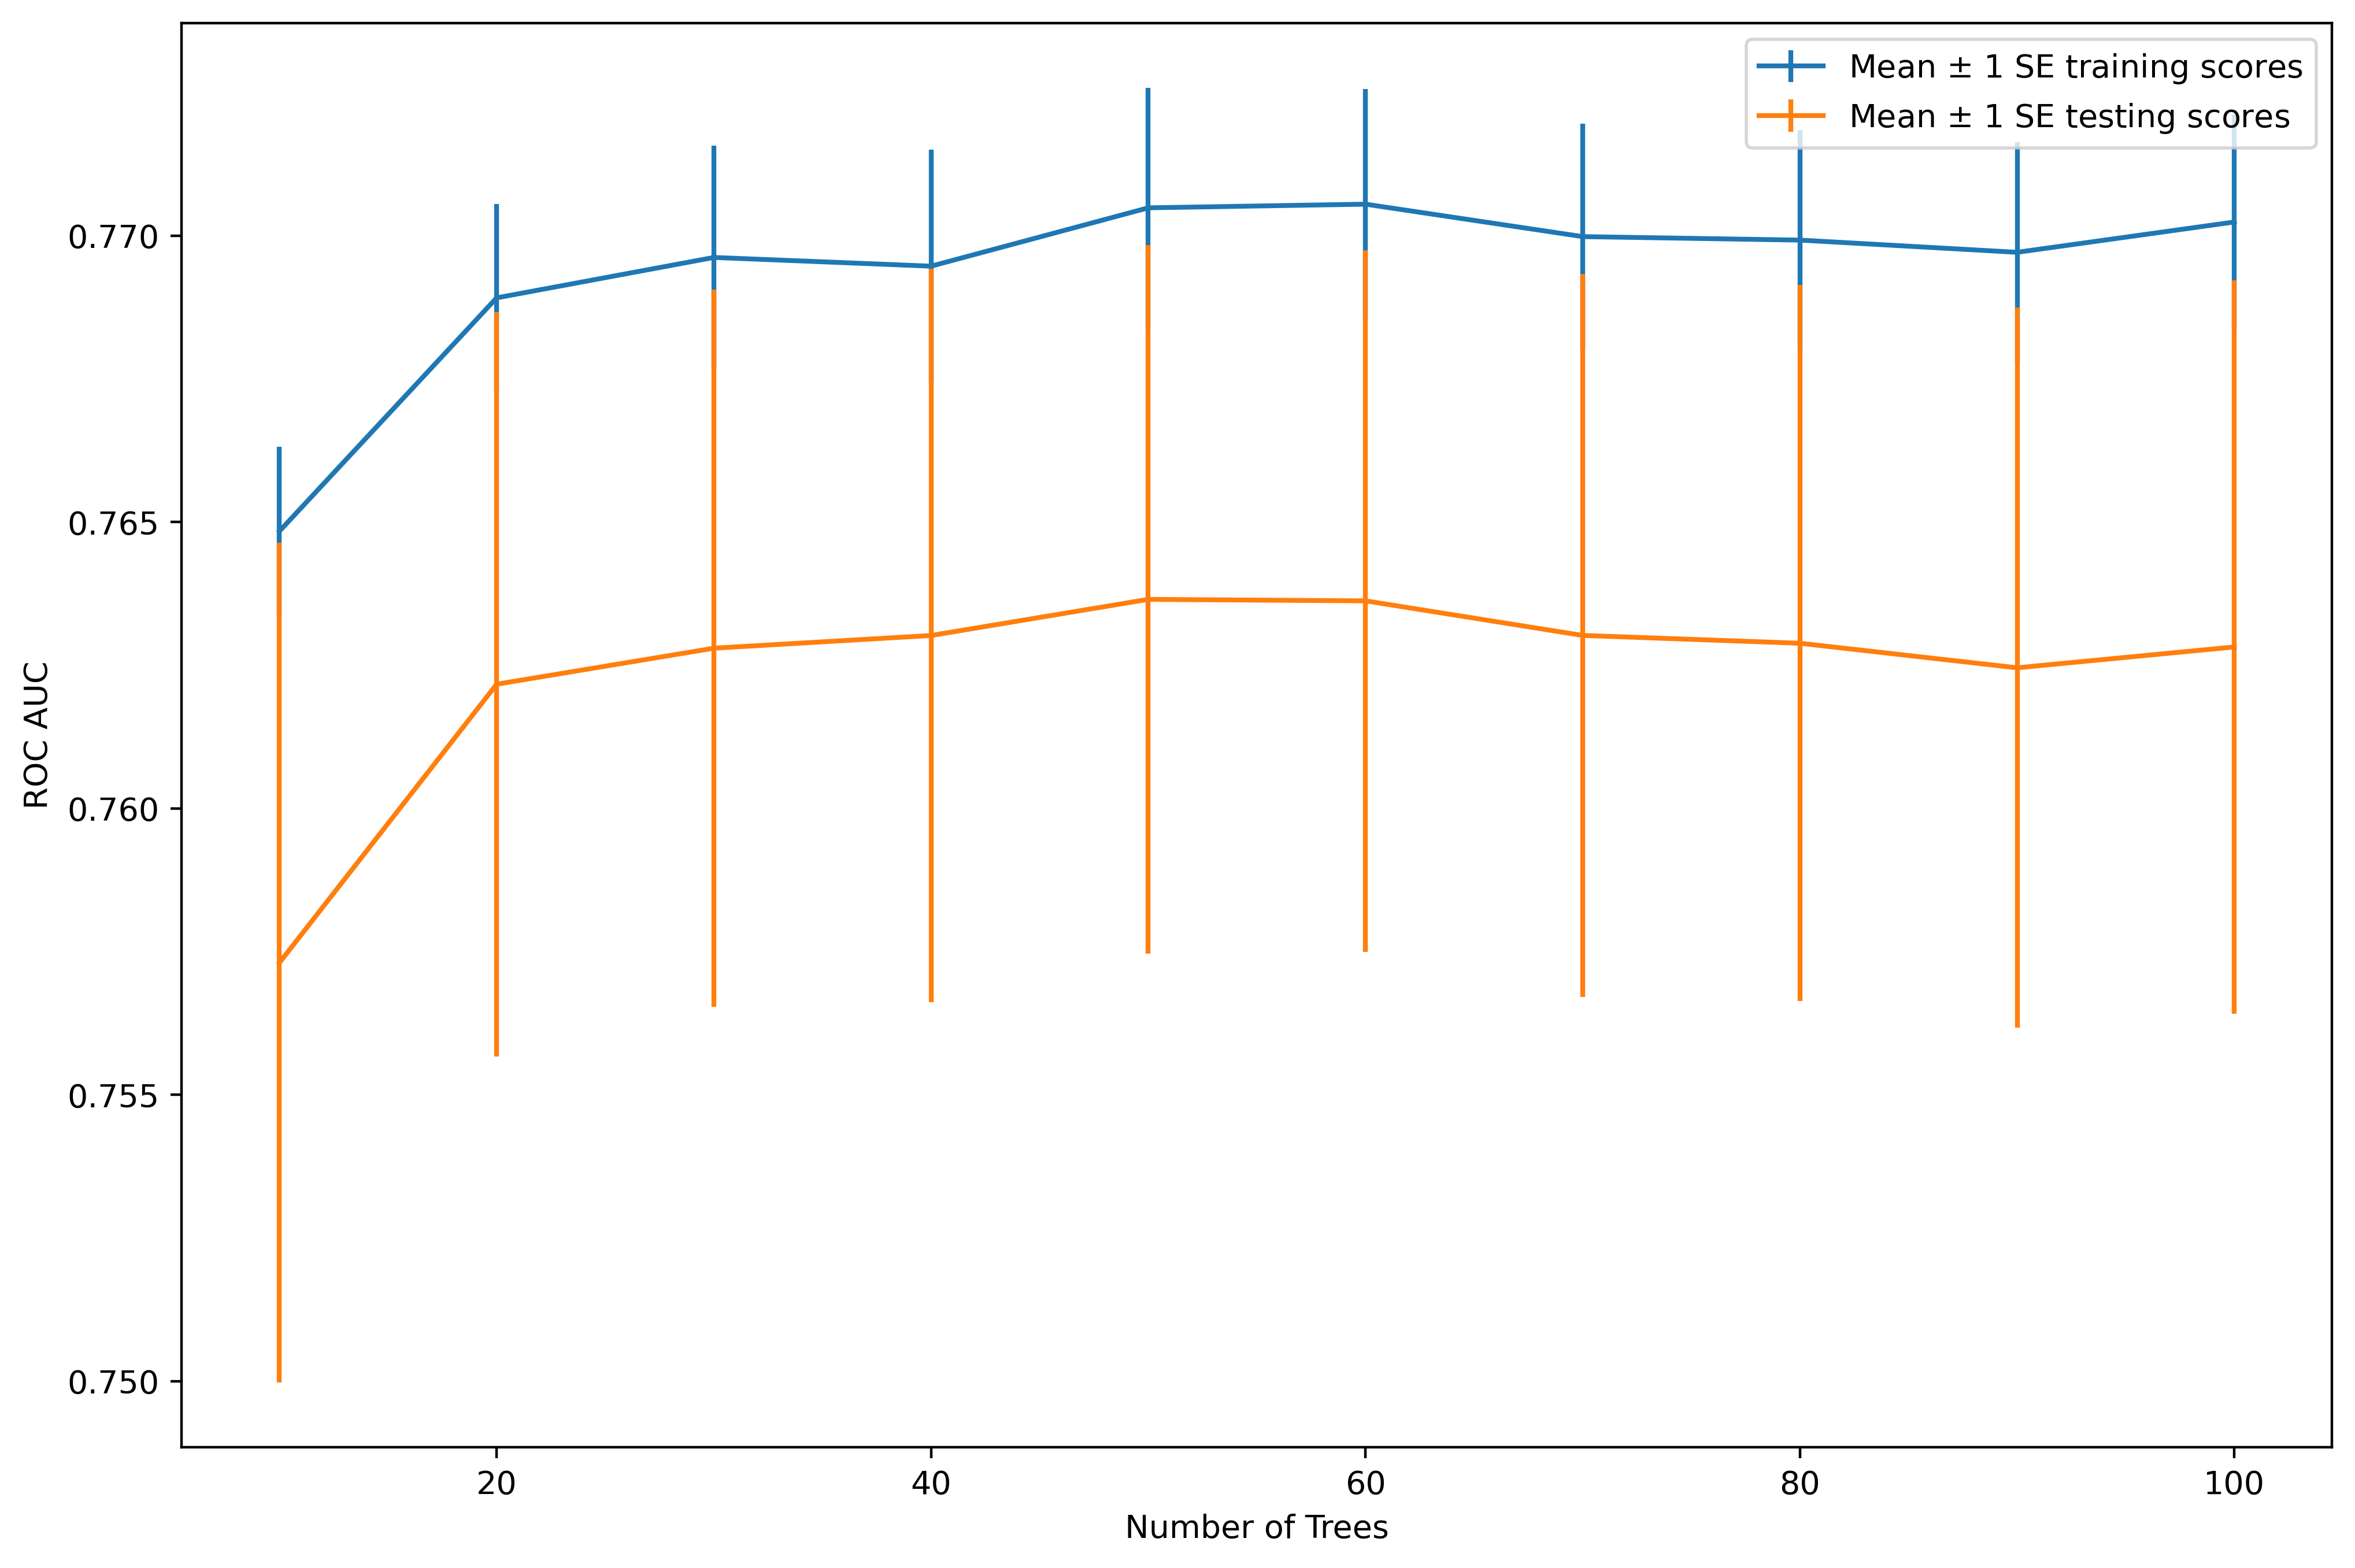

In [511]:
plt.figure(figsize=(12,8))
ax = plt.axes()
ax.errorbar(cv_rf_ex_results_df['param_n_estimators'],       # x-axis of line plot
            cv_rf_ex_results_df['mean_train_score'],      # y-axis of line plot
            yerr=cv_rf_ex_results_df['std_train_score'] / np.sqrt(4), # standard error as error bar
            label='Mean $\pm$ 1 SE training scores')
ax.errorbar(cv_rf_ex_results_df['param_n_estimators'],
            cv_rf_ex_results_df['mean_test_score'],
            yerr=cv_rf_ex_results_df['std_test_score'] / np.sqrt(4),
            label='Mean $\pm$ 1 SE testing scores')
ax.legend()
plt.xlabel('Number of Trees')
plt.ylabel('ROC AUC')

In [512]:
cv_rf_ex.best_params_

{'n_estimators': 50}

<Axes: >

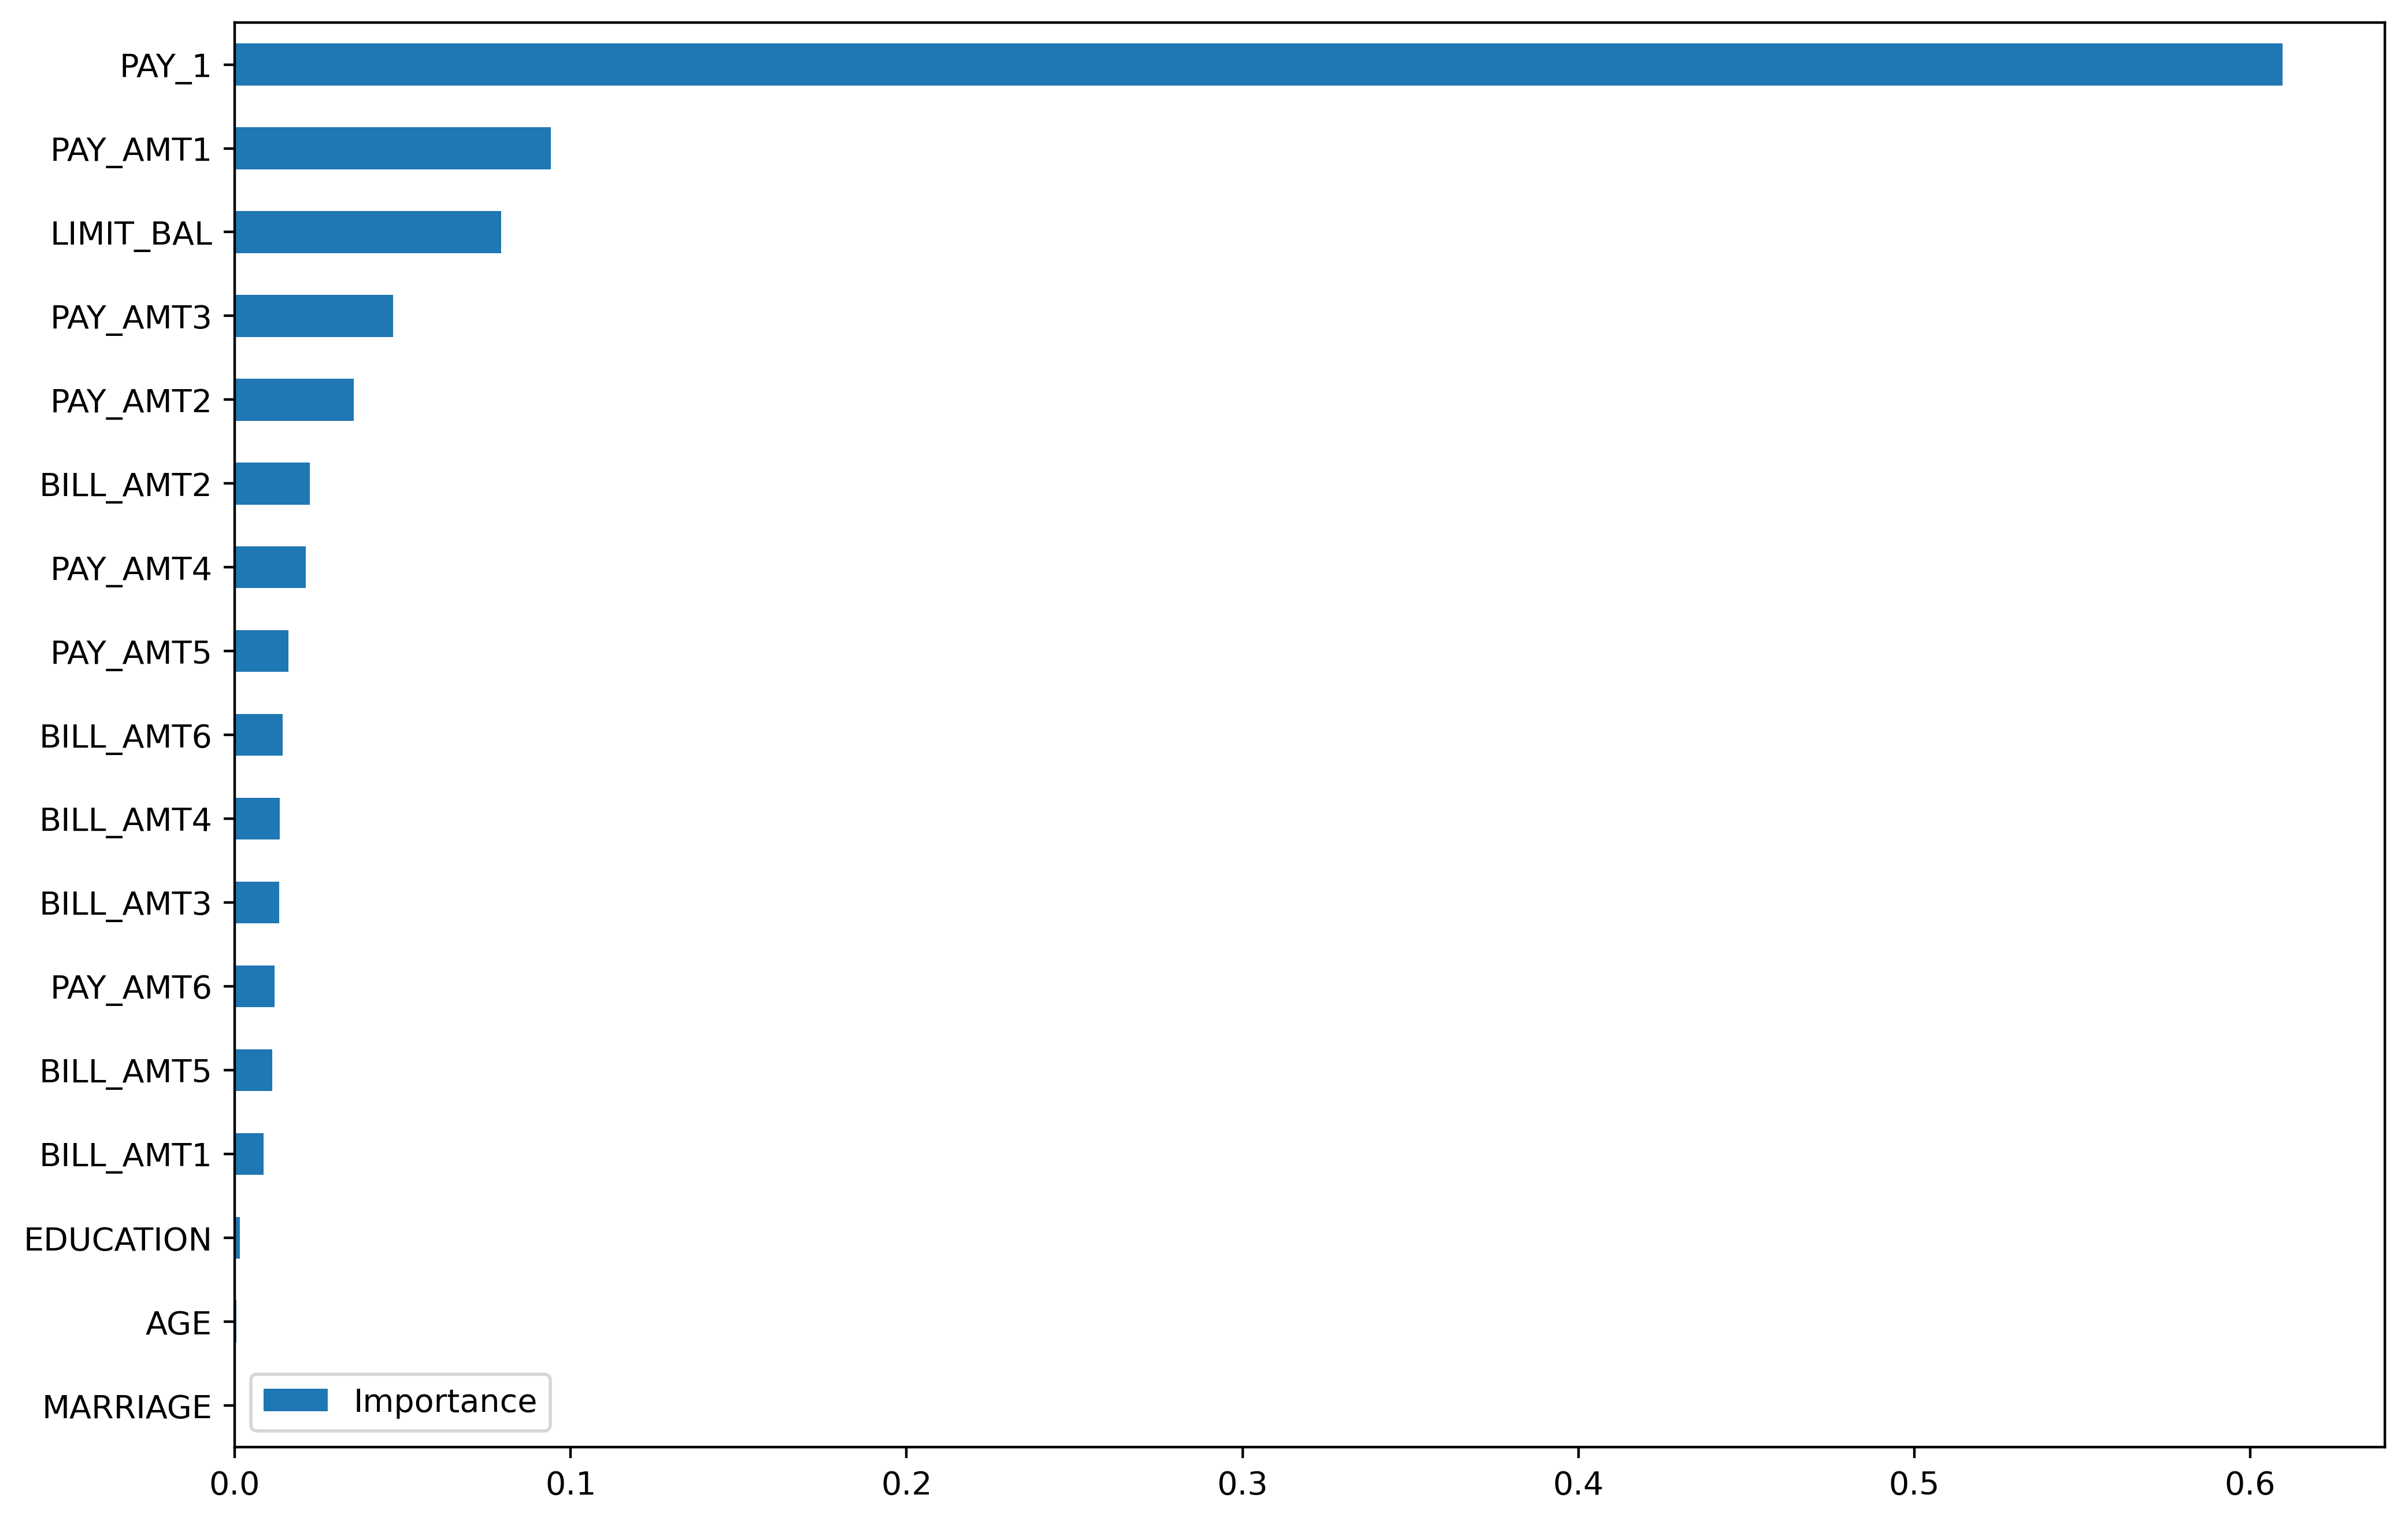

In [513]:
feat_imp_df = pd.DataFrame({
    'Importance' : cv_rf_ex.best_estimator_.feature_importances_ # this is why you should refit=True cv
},
index=features_response[:-1])
feat_imp_df.sort_values(by='Importance', 
                        ascending=True).plot.barh(figsize=(12,8)) # gotta sort ascending for descending bars

#### Checkerboard Graph

For visualizing three-dimensional data, where the third dimension is visualized with color using plt.pcolormesh().

In [514]:
xx_example, yy_example = np.meshgrid(range(5), range(5)) # 5 tick values, 
print(xx_example)
print(yy_example)

[[0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]]
[[0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 4 4 4]]


In [515]:
z_example = np.arange(1,17).reshape(4,4)        # 4 z-values
z_example

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12],
       [13, 14, 15, 16]])

Text(0, 0.5, 'Y coordinate')

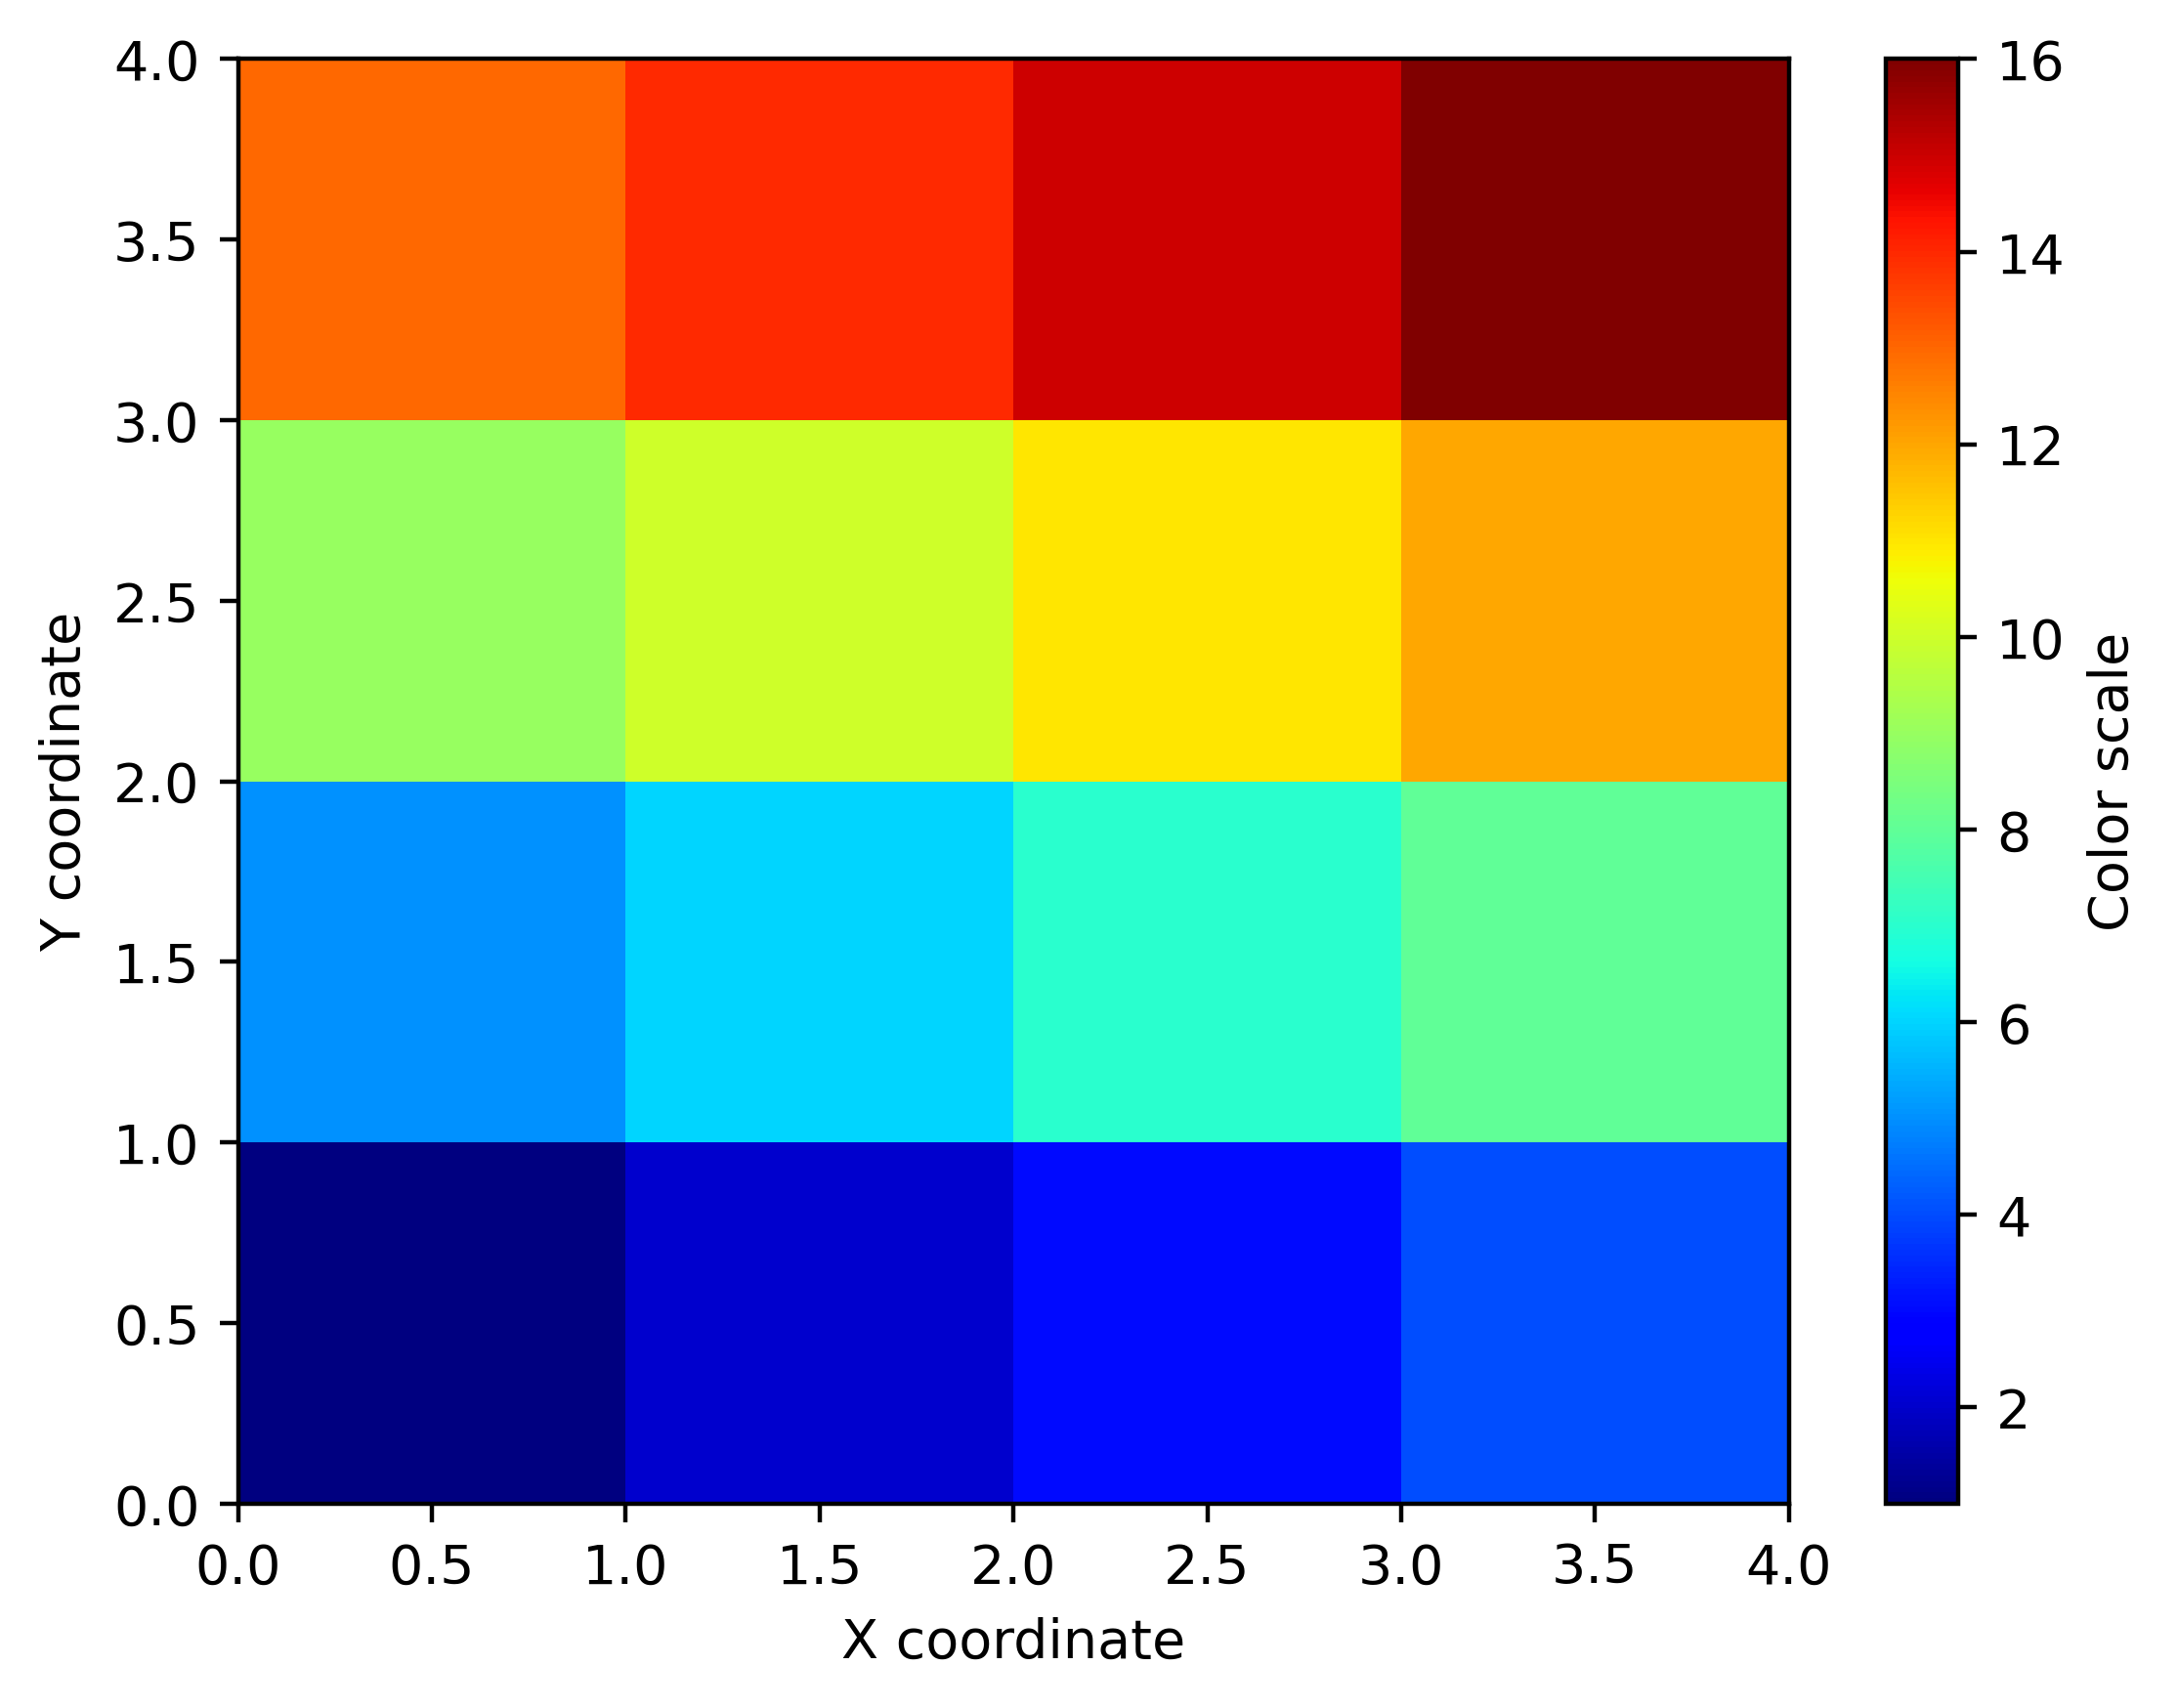

In [516]:
# Checkerboard graph
ax = plt.axes()
pcolor_ex = ax.pcolormesh(xx_example, yy_example, z_example, cmap=plt.cm.jet) # think contourf
plt.colorbar(pcolor_ex, label='Color scale') # we store the
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')

#### Cross-validation grid search with random forest

In [520]:
# {parameter name : list of parameter values}
rf_params = {'max_depth': [3,6,9,12],
             'n_estimators': [10,50,100,200]}

In [521]:
rf = RandomForestClassifier(n_estimators=10,    # just for initialization, will be grid-searched
                            criterion='gini',
                            max_depth=3,        # just for initialization, will be grid-searched
                            min_samples_split=2,
                            min_samples_leaf=1,
                            min_weight_fraction_leaf=0.0,
                            max_features='sqrt',
                            max_leaf_nodes=None,
                            min_impurity_decrease=0.0,
                            bootstrap=True,
                            oob_score=False,
                            n_jobs=None,
                            random_state=4,
                            verbose=0,
                            warm_start=False,
                            class_weight=None
                            )

In [522]:
cv_rf = GridSearchCV(rf,
                     param_grid=rf_params,
                     scoring='roc_auc',
                     n_jobs=1,
                     refit=True,                # important, for predict / predict_proba / feature_importances
                     cv=4,
                     verbose=2,
                     error_score=np.nan,
                     return_train_score=True)   # cv_rf.cv_results_ will include train scores to asses overfit

In [523]:
cv_rf.fit(X_train, y_train)

Fitting 4 folds for each of 16 candidates, totalling 64 fits
[CV] END .......................max_depth=3, n_estimators=10; total time=   0.1s
[CV] END .......................max_depth=3, n_estimators=10; total time=   0.1s
[CV] END .......................max_depth=3, n_estimators=10; total time=   0.1s
[CV] END .......................max_depth=3, n_estimators=10; total time=   0.1s
[CV] END .......................max_depth=3, n_estimators=50; total time=   0.5s
[CV] END .......................max_depth=3, n_estimators=50; total time=   0.5s
[CV] END .......................max_depth=3, n_estimators=50; total time=   0.5s
[CV] END .......................max_depth=3, n_estimators=50; total time=   0.5s
[CV] END ......................max_depth=3, n_estimators=100; total time=   0.9s
[CV] END ......................max_depth=3, n_estimators=100; total time=   1.0s
[CV] END ......................max_depth=3, n_estimators=100; total time=   1.0s
[CV] END ......................max_depth=3, n_es

GridSearchCV(cv=4,
             estimator=RandomForestClassifier(max_depth=3, n_estimators=10,
                                              random_state=4),
             n_jobs=1,
             param_grid={'max_depth': [3, 6, 9, 12],
                         'n_estimators': [10, 50, 100, 200]},
             return_train_score=True, scoring='roc_auc', verbose=2)

In [524]:
# store cross-validation results in a dataframe
cv_rf_results_df = pd.DataFrame(cv_rf.cv_results_)

In [525]:
cv_rf_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.098245,0.004938,0.004710,0.000485,3,10,"{'max_depth': 3, 'n_estimators': 10}",0.739183,0.746599,0.772127,0.771322,0.757308,0.014656,15,0.767973,0.767158,0.760550,0.763683,0.764841,0.002955
1,0.459293,0.003701,0.013369,0.000145,3,50,"{'max_depth': 3, 'n_estimators': 50}",0.748009,0.755878,0.779465,0.771250,0.763651,0.012379,12,0.775241,0.774025,0.765732,0.766947,0.770486,0.004191
2,0.927143,0.012314,0.025224,0.000998,3,100,"{'max_depth': 3, 'n_estimators': 100}",0.747221,0.753924,0.779195,0.770937,0.762819,0.012811,13,0.774340,0.773598,0.766103,0.766914,0.770238,0.003750
3,1.825013,0.008527,0.047690,0.000214,3,200,"{'max_depth': 3, 'n_estimators': 200}",0.747454,0.753057,0.777644,0.771729,0.762471,0.012550,14,0.774453,0.773534,0.766139,0.767404,0.770382,0.003653
4,0.162604,0.002891,0.005035,0.000069,6,10,"{'max_depth': 6, 'n_estimators': 10}",0.752905,0.758904,0.780036,0.774017,0.766466,0.010980,11,0.795911,0.796476,0.793695,0.796446,0.795632,0.001141
5,0.813805,0.018482,0.017239,0.000177,6,50,"{'max_depth': 6, 'n_estimators': 50}",0.760089,0.765251,0.788567,0.778669,0.773144,0.011193,8,0.807081,0.805109,0.799176,0.801229,0.803149,0.003113
6,1.603717,0.008089,0.032770,0.000227,6,100,"{'max_depth': 6, 'n_estimators': 100}",0.760964,0.765515,0.788793,0.778936,0.773552,0.011004,7,0.808194,0.806130,0.800846,0.803123,0.804573,0.002808
7,3.198748,0.008250,0.063298,0.000415,6,200,"{'max_depth': 6, 'n_estimators': 200}",0.761481,0.765319,0.787854,0.779745,0.773600,0.010682,6,0.808276,0.806853,0.800682,0.804006,0.804954,0.002906
8,0.226512,0.000823,0.006036,0.000065,9,10,"{'max_depth': 9, 'n_estimators': 10}",0.757853,0.755444,0.781544,0.773823,0.767166,0.010899,10,0.854161,0.856197,0.850317,0.852039,0.853178,0.002211
9,1.121983,0.004875,0.021712,0.000252,9,50,"{'max_depth': 9, 'n_estimators': 50}",0.763956,0.764420,0.786690,0.780255,0.773830,0.009908,4,0.867242,0.871380,0.868213,0.867390,0.868557,0.001672


In [530]:
cv_rf_results_df.max(numeric_only=True)

mean_fit_time          5.598769
std_fit_time           0.018482
mean_score_time        0.100171
std_score_time         0.000998
split0_test_score      0.765910
split1_test_score      0.767541
split2_test_score      0.790255
split3_test_score      0.783513
mean_test_score        0.776199
std_test_score         0.014656
rank_test_score       16.000000
split0_train_score     0.945018
split1_train_score     0.949378
split2_train_score     0.946415
split3_train_score     0.944689
mean_train_score       0.946375
std_train_score        0.004263
dtype: float64

In [536]:
cv_rf_results_df.param_max_depth

0      3
1      3
2      3
3      3
4      6
5      6
6      6
7      6
8      9
9      9
10     9
11     9
12    12
13    12
14    12
15    12
Name: param_max_depth, dtype: object

In [531]:
# xticks from meshgrid of range of number of each hyperparameter +1 (for 0 tick)
xx_rf, yy_rf = np.meshgrid(range(5), range(5))  # max_depth, n_estimators both had 4 + 1 = 5 values

In [532]:
# colormap
cm_rf = plt.cm.jet

Text(0, 0.5, 'Maximum depth')

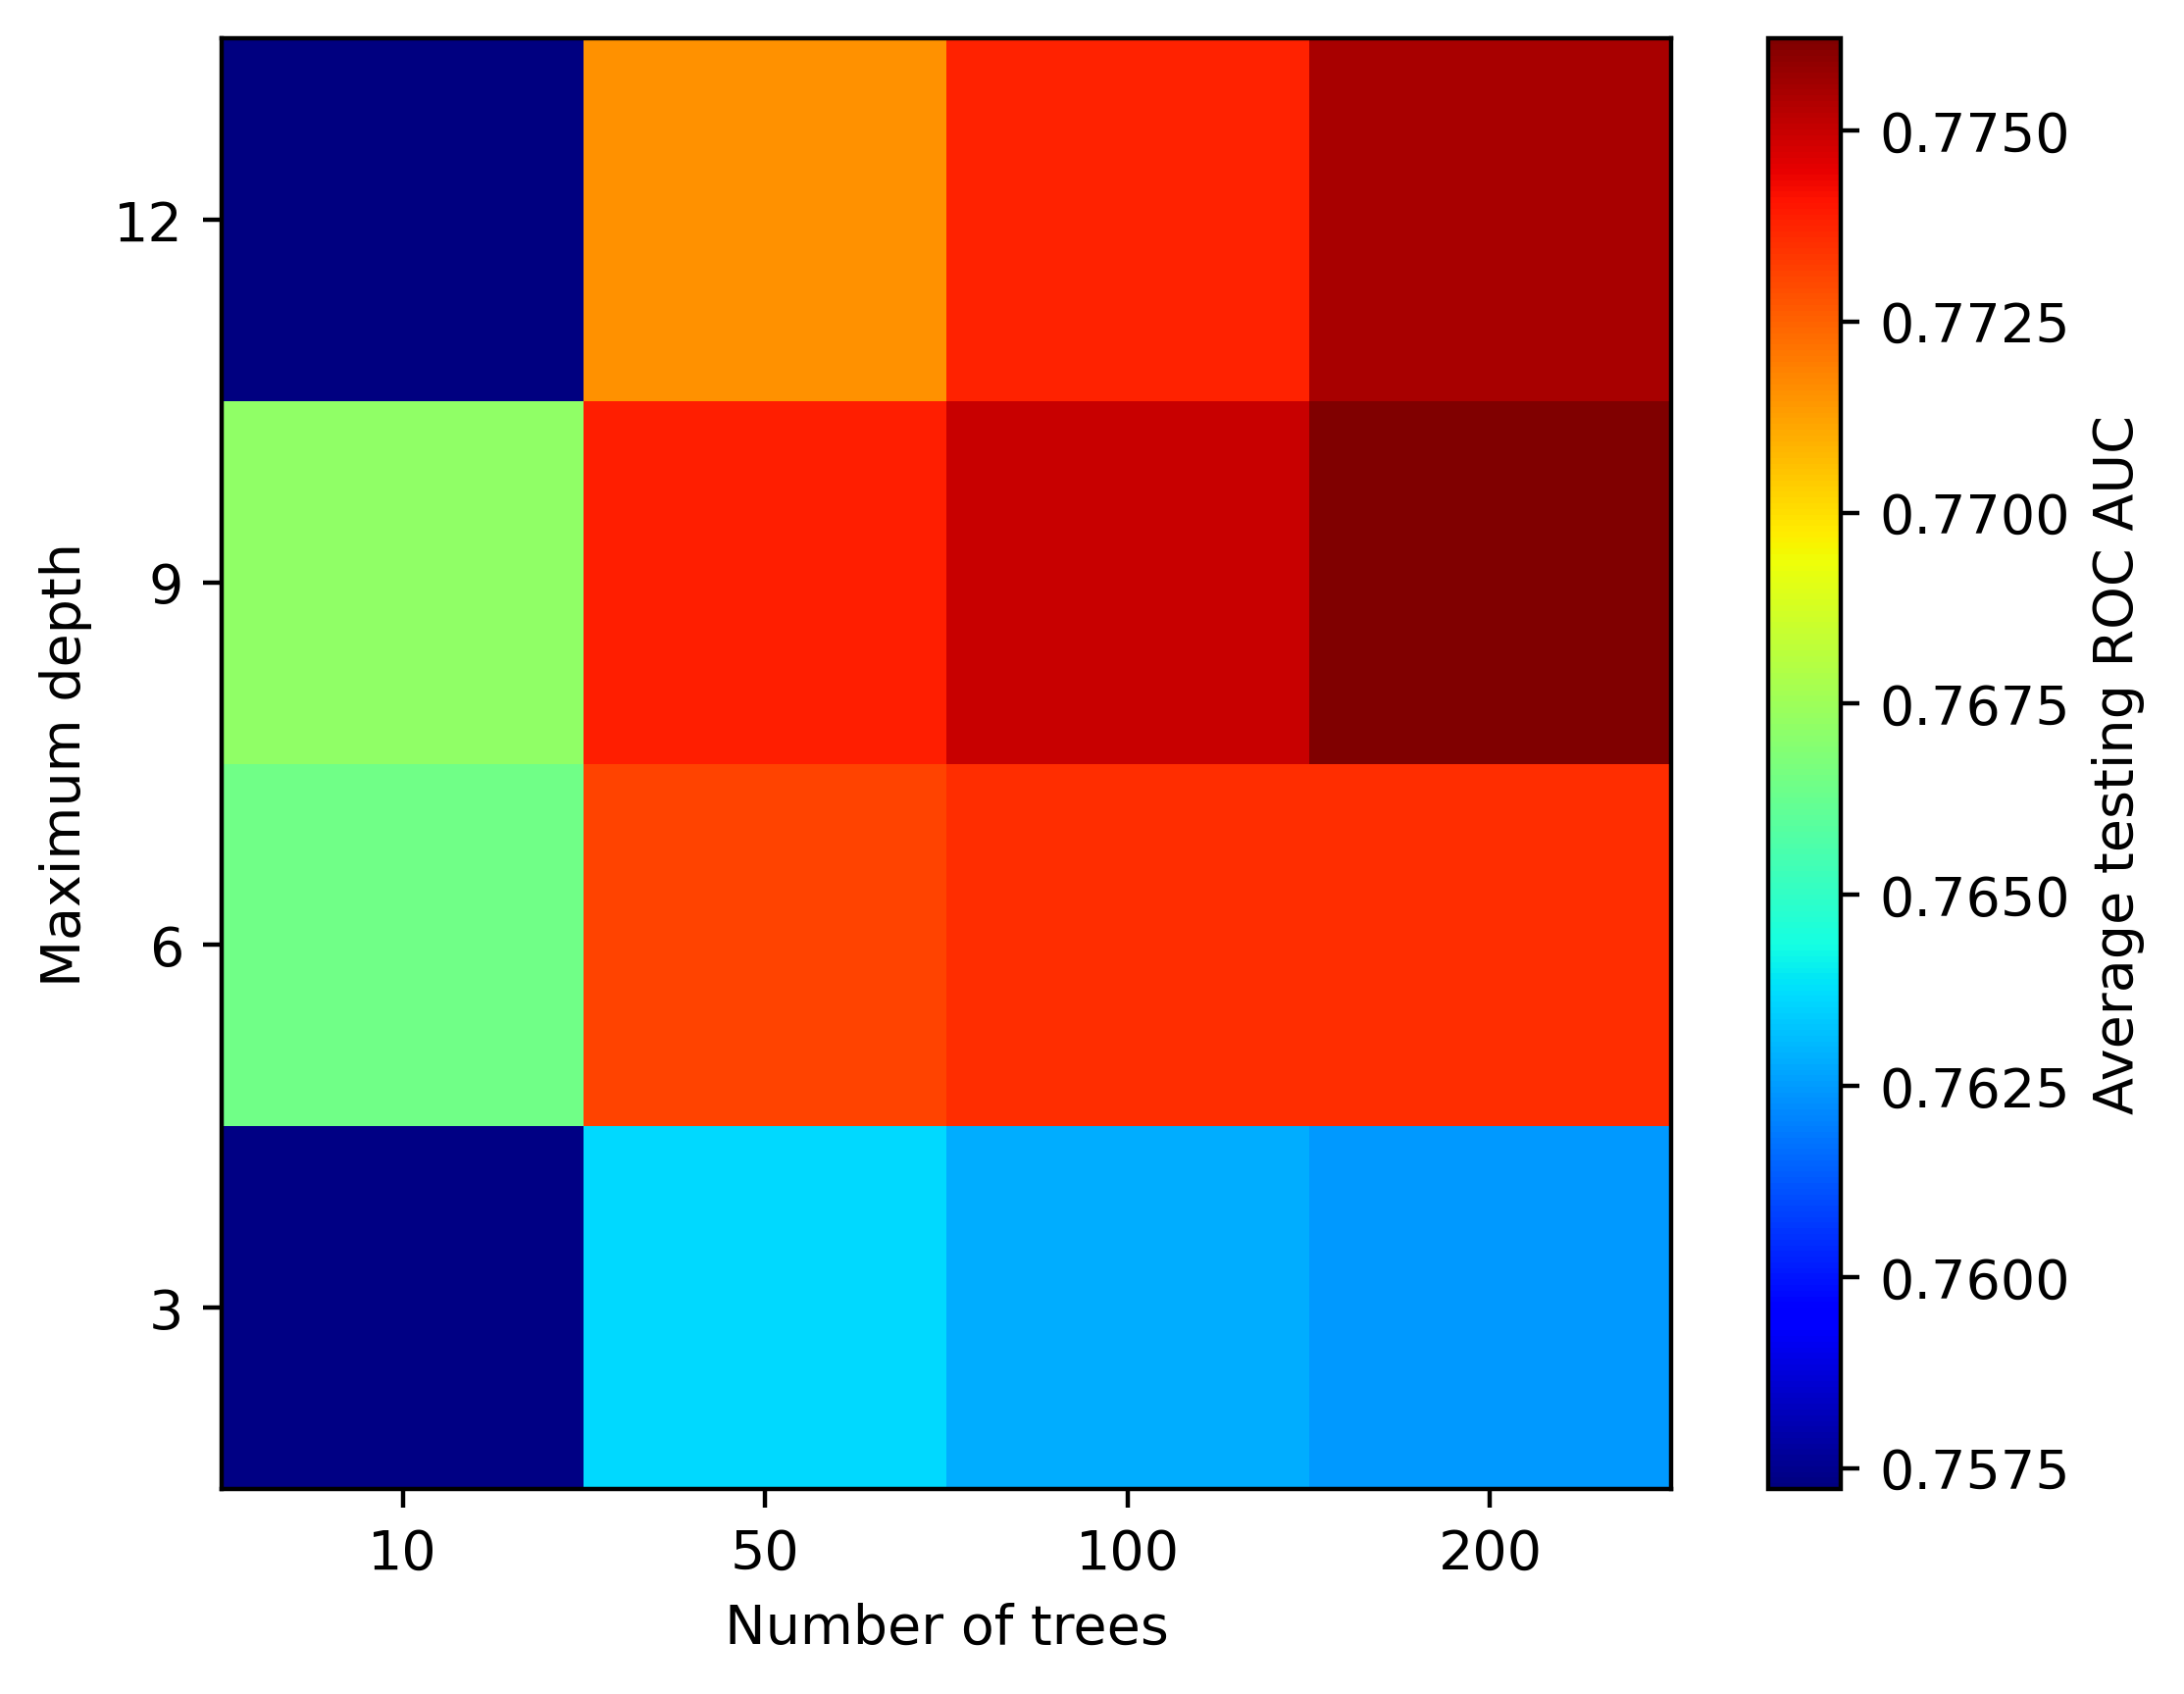

In [533]:
ax_rf = plt.axes()
pcolor_graph = ax_rf.pcolormesh(
    xx_rf, yy_rf,                   # this is for the xticks will be labeled later
    cv_rf_results_df['mean_test_score'].values.reshape((4,4)),  # z values, reshaped in (4,4) grid for 5x5points
    cmap=cm_rf) # colormap already initialized
plt.colorbar(pcolor_graph, label='Average testing ROC AUC') # colorbar
ax_rf.set_aspect('equal')
ax_rf.set_xticks([0.5, 1.5, 2.5, 3.5])  # positions of the xticks given in scale of xx_rf, yy_rf
ax_rf.set_yticks([0.5, 1.5, 2.5, 3.5])
ax_rf.set_xticklabels(
    [str(tick_label) for tick_label in rf_params['n_estimators']])  # unique hyperparameter values as strings
ax_rf.set_yticklabels(
    [str(tick_label) for tick_label in rf_params['max_depth']])
ax_rf.set_xlabel('Number of trees')
ax_rf.set_ylabel('Maximum depth')

In [539]:
cv_rf_results_df[['param_max_depth', 'param_n_estimators', 'mean_test_score']]

,param_max_depth,param_n_estimators,mean_test_score
0,3,10,0.757308
1,3,50,0.763651
2,3,100,0.762819
3,3,200,0.762471
4,6,10,0.766466
5,6,50,0.773144
6,6,100,0.773552
7,6,200,0.773600
8,9,10,0.767166
9,9,50,0.773830


In [542]:
cv_rf.best_params_

{'max_depth': 9, 'n_estimators': 200}

In [543]:
feat_imp_df_act = pd.DataFrame({
    'Feature name': features_response[:-1],
    'Importance': cv_rf.best_estimator_.feature_importances_
})

In [544]:
feat_imp_df_act.sort_values('Importance', ascending=False)

,Feature name,Importance
4,PAY_1,0.437439
0,LIMIT_BAL,0.059961
11,PAY_AMT1,0.059434
12,PAY_AMT2,0.045518
13,PAY_AMT3,0.043299
5,BILL_AMT1,0.042195
6,BILL_AMT2,0.041562
7,BILL_AMT3,0.037268
14,PAY_AMT4,0.034321
8,BILL_AMT4,0.034123


In [546]:
cv_rf_results_df['param_max_depth'].values.reshape((4,4))

array([[10, 50, 100, 200],
       [10, 50, 100, 200],
       [10, 50, 100, 200],
       [10, 50, 100, 200]], dtype=object)

In [547]:
cv_rf_results_df['param_n_estimators'].values.reshape((4,4))

array([[10, 50, 100, 200],
       [10, 50, 100, 200],
       [10, 50, 100, 200],
       [10, 50, 100, 200]], dtype=object)

In [548]:
xx_rf

array([[0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4]])

In [549]:
yy_rf

array([[0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [2, 2, 2, 2, 2],
       [3, 3, 3, 3, 3],
       [4, 4, 4, 4, 4]])

In [575]:
feat_imp_df = pd.DataFrame({'Feat_Importances'  : cv_rf.best_estimator_.feature_importances_},
                            index = features_response[:-1],).sort_values(by='Feat_Importances',
            ascending=True)

In [576]:
feat_imp_df

,Feat_Importances
MARRIAGE,0.004504
EDUCATION,0.007545
AGE,0.026774
PAY_AMT6,0.029070
PAY_AMT5,0.030734
BILL_AMT5,0.032413
BILL_AMT6,0.033839
BILL_AMT4,0.034123
PAY_AMT4,0.034321
BILL_AMT3,0.037268


Text(0.5, 1.0, 'Relative Feature Importances')

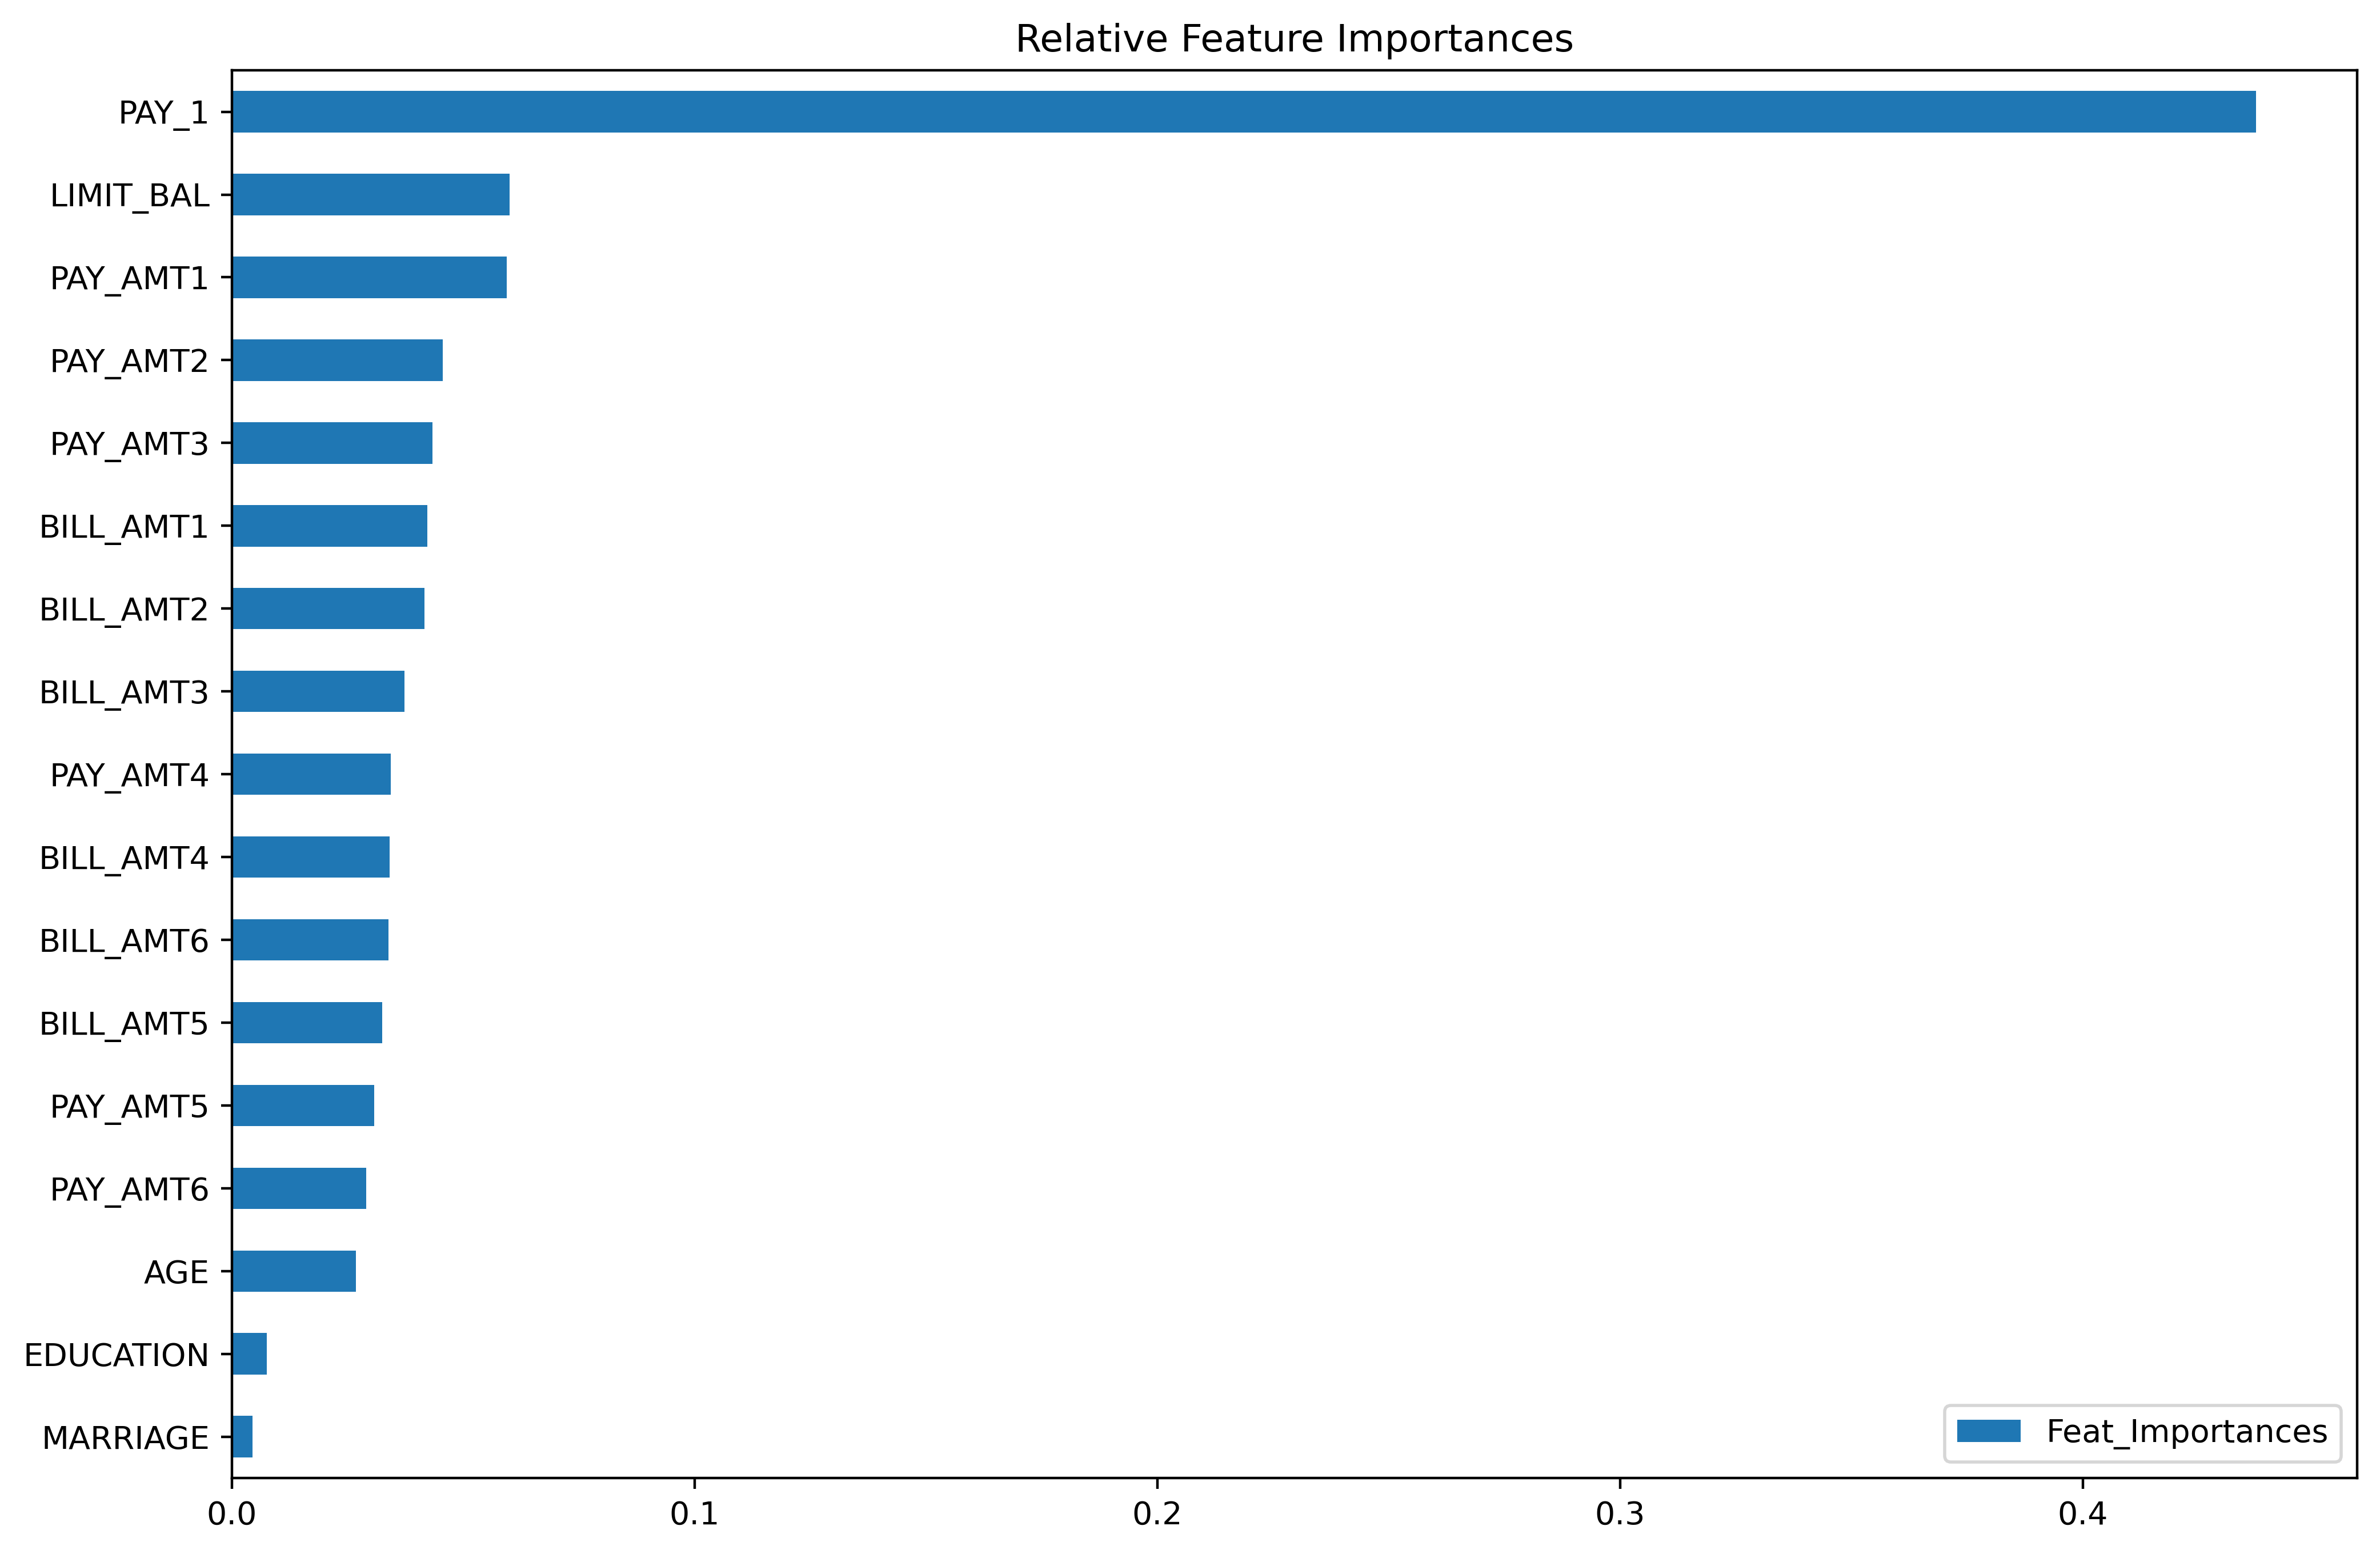

In [578]:
a = feat_imp_df.plot.barh(figsize=(12,8))
a.set_title('Relative Feature Importances')